# Packages

In [1]:
#%cd /content/drive/MyDrive/MscThesis
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import pandas as pd
import time
import gwpy
import nds2 # conda config --add channels conda-forge \n conda install python-nds2-client
import numba

from gwpy.table import EventTable
from gwpy.table import GravitySpyTable
from gwpy.detector import ChannelList, Channel
from gwpy.time import tconvert
from gwpy.timeseries import TimeSeries #if this does not work, remove h5py and reinstall h5py
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.table import vstack
from datetime import datetime
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torchvision
import torchvision.models
import torchvision.transforms as transforms
from torch.optim import SGD, Adam, AdamW
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import DatasetFolder, ImageFolder
from tqdm import tqdm
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, \
accuracy_score
from avalanche.models import SlimResNet18, MTSlimResNet18, SimpleCNN
from avalanche.models import as_multitask, IncrementalClassifier
from avalanche.models.utils import avalanche_model_adaptation
from avalanche.training import Naive, LwF, GenerativeReplay, ICaRLLossPlugin, ICaRL, EWC, AR1, LFL, AGEM
from avalanche.logging import (
    InteractiveLogger,
    TextLogger,
    CSVLogger,
)
from avalanche.training.plugins import EvaluationPlugin, ReplayPlugin, LwFPlugin, EarlyStoppingPlugin, AGEMPlugin
from avalanche.training.plugins.lr_scheduling import LRSchedulerPlugin
from avalanche.benchmarks import nc_benchmark, ni_benchmark
from avalanche.benchmarks.utils import AvalancheDataset
from avalanche.benchmarks.scenarios.dataset_scenario import benchmark_from_datasets
from avalanche.benchmarks.scenarios.supervised import class_incremental_benchmark
from avalanche.evaluation.metrics import forgetting_metrics, accuracy_metrics,loss_metrics, \
timing_metrics, cpu_usage_metrics, StreamConfusionMatrix, disk_usage_metrics, gpu_usage_metrics, \
confusion_matrix_metrics, bwt_metrics, forward_transfer_metrics, ram_usage_metrics, images_samples_metrics
from avalanche.evaluation.metrics import Accuracy, BWT, Forgetting, ForwardTransfer
import multiprocessing as mp

import my_utils
import my_architectures
import my_dataloaders
import my_gwpy_and_fractals
import my_transformations

IMG_SIZE = (224,224)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# calculating the amount of workers usable
number_of_workers = mp.cpu_count()
number_of_workers = int(number_of_workers/2)
print(number_of_workers)

4


In [2]:
current_dir = %pwd
print(current_dir)

C:\Users\Brian.Baert\Documents\GitHub\MscThesis


In [3]:
# Setting the correct directories
#train_dir = 'D:\\Users\\Brian\\TrainingSet_CL_1\\TrainingSet_CL_1'
train_dir = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_1'
#train_dir_2 = 'D:\\Users\Brian\\TrainingSet_CL_2\\TrainingSet_CL_2'
train_dir_2 = 'C:\\Users\\Brian.Baert\\TrainingSet_CL_2'
#val_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
val_dir = 'C:\\Users\\Brian.Baert\\ValidationSet_CL'
#test_dir = 'D:\\Users\\Brian\\TestSet_CL\\TestSet_CL'
test_dir = 'C:\\Users\\Brian.Baert\\TestSet_CL'

# Read in class labels
class_file = open("classes.txt", "r")
classes = class_file.read()
classes = classes.split(", ")

In [4]:
# Extract glitches and IFO ---> ONLY ONCE
L1_filename = "L1_glitches.txt"
H1_filename = "H1_glitches.txt"

glitch_names_L1 = set()
glitch_names_H1 = set()

for root, _, files in os.walk(train_dir):
    for filename in files:
        if filename.startswith("H1_"):
            parts = filename.split("_")
            if len(parts) >= 3:
                glitch_names_H1.add(parts[1])
        if filename.startswith("L1_"):
            parts = filename.split("_")
            if len(parts) >=2:
                glitch_names_L1.add(parts[1])

with open(os.path.join(current_dir, L1_filename), "w") as output_file:
    for name in glitch_names_L1:
        output_file.write(f"{name}\n")
        
with open(os.path.join(current_dir, H1_filename), "w") as output_file:
    for name in glitch_names_H1:
        output_file.write(f"{name}\n")

In [5]:
filenames = []
with open("L1_glitches.txt", "r") as file:
    for line in file:
        filenames.append(line.strip())

In [6]:
# Set the environment variables
os.environ["GRAVITYSPY_DATABASE_USER"] = "mla"
os.environ["GRAVITYSPY_DATABASE_PASSWD"] = "gl1tch35Rb4d!"
glitch_labels = ['1400Ripples', '1080Lines', 'Air_Compressor', 
                 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 
                 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch', 'None_of_the_Above', 
                 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 
                 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
O3b_start = 1256655618
O3b_stop = 1269363618

In [43]:
O3b_csv = pd.read_csv('Data/data_o3b_high_confidence.csv')
O3b_csv[O3b_csv['ifo']=='L1'].head(20)

Unnamed: 0       GPStime  peakFreq        snr     amplitude  centralFreq  \
1             1  1.263653e+09    30.341  14378.516  2.390000e-19      154.733   
2             2  1.263653e+09    30.341  14378.516  2.390000e-19      154.733   
3             3  1.268885e+09    39.789  14115.183  1.210000e-19     3980.241   
5             5  1.257763e+09    32.173  11060.086  1.350000e-19     3980.241   
6             6  1.257763e+09    32.173  11060.086  1.350000e-19     3980.241   
16           16  1.257668e+09    39.789   8906.733  7.580000e-20     3980.241   
18           18  1.260445e+09    39.789   8655.928  6.830000e-20     3980.241   
22           22  1.262676e+09    32.173   8423.196  9.210000e-20     3980.241   
34           34  1.258532e+09   333.030   7363.322  2.690000e-20     3980.241   
46           46  1.260326e+09   269.285   6542.856  2.320000e-20     3980.241   
48           48  1.257923e+09    49.208   6443.800  4.310000e-20     3980.241   
54           54  1.257439e+09   333.030   6281.512  2.370000e-20     3980.241   
65           65  1.261012e+09   333.030   5930.400  2.180000e-20     3980.241   
69           69  1.261799e+09   411.865   5814.335  2.270000e-20     3980.241   
71           71  1.264613e+09    49.208   5733.733  3.490000e-20     3980.241   
80           80  1.259503e+09    75.263   5488.282  2.280000e-20     3980.241   
82           82  1.268306e+09   411.865   5449.805  2.090000e-20     3980.241   
83           83  1.257289e+09   333.030   5380.538  2.000000e-20     3980.241   
94           94  1.258644e+09    32.173   5021.328  5.260000e-20     3878.874   
101         101  1.260113e+09    60.857   4912.460  2.470000e-20     3980.241   

     duration    bandwidth  chisq  chisqDof  confidence          id ifo  \
1       1.000   289.466156    0.0       0.0         1.0  8axhDW5Dto  L1   
2       1.000   289.466156    0.0       0.0         1.0  2JNFX8twSG  L1   
3      11.054  7940.482910    0.0       0.0         1.0  lwg1qgOIFz  L1   
5       9.845  7940.482910    0.0       0.0         1.0  lVrpQMt3Fa  L1   
6       9.845  7940.482910    0.0       0.0         1.0  aEEeGRJO1I  L1   
16     10.750  7940.482910    0.0       0.0         1.0  WB1uzmuMe2  L1   
18      7.500  7940.482910    0.0       0.0         1.0  3y03nz8eLG  L1   
22     10.750  7940.482910    0.0       0.0         1.0  Vdu0t4J6sk  L1   
34      7.526  7940.482910    0.0       0.0         1.0  5Ehmj4MZ3m  L1   
46      6.750  7940.482910    0.0       0.0         1.0  qfADrRgocE  L1   
48      7.271  7940.482910    0.0       0.0         1.0  mLgceKxkhs  L1   
54      6.875  7940.482910    0.0       0.0         1.0  oneCYhMLE2  L1   
65      4.938  7940.482910    0.0       0.0         1.0  YeW2uY0jZO  L1   
69      4.750  7940.482910    0.0       0.0         1.0  CWWn6EGzIV  L1   
71      6.750  7940.482910    0.0       0.0         1.0  zBWOJsT9CL  L1   
80      6.250  7940.482910    0.0       0.0         1.0  DiA4oryKds  L1   
82      7.000  7940.482910    0.0       0.0         1.0  Pguv6NAacA  L1   
83      5.156  7940.482910    0.0       0.0         1.0  KyMZaB2GNT  L1   
94      8.500  7737.748047    0.0       0.0         1.0  k0hYO47qyv  L1   
101     6.375  7940.482910    0.0       0.0         1.0  5n4gCXHIoM  L1   

              label                                             imgUrl  \
1    Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
2    Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
3    Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
5    Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
6    Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
16   Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
18   Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
22   Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~gravity...   
34   Extremely_Loud  https://ldas-jobs.ligo-la.caltech.edu/~g

In [39]:
#glitch_id = 'RMZcdeBCbb'
glitch_id = '6qQpdFEYLg'
list(O3b_csv[O3b_csv.id == glitch_id]['imgUrl'])

['https://ldas-jobs.ligo-wa.caltech.edu/~gravityspy/runs/O3/o169RsNFtj/6qQpdFEYLg.png']

In [25]:
glitch_start_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])-2
glitch_stop_time = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])+2

In [40]:
step = 0.1
sampling_rate = 16384
#sampling_rate = 512
decimate = 16
#channel = 'L1:DCS-CALIB_STRAIN_C01_AR'
channel = 'H1:DCS-CALIB_STRAIN_C01_AR'
#channel = 'L1:PEM-EY_MIC_VEA_PLUSY_DQ'
#channel = 'H1:LSC-PRCL_OUT_DQ' --> not available
#channel = 'H1:LSC-PRCL_IN1_DQ' --> not available
#channel = 'L1:LSC-PRCL_IN1_DQ'
#channel = 'L1:LSC-PRCL_OUT_DQ'
#channel = 'L1:ASC-CHARD_Y_OUT_DQ'
#server = 'losc-nds.ligo.org'
server = 'nds.gwosc.org'
alpha = 1
data_end = sampling_rate * (glitch_stop_time - glitch_start_time)
data = pd.DataFrame(columns=['time', 'value'])
data_length = int((glitch_stop_time - glitch_start_time) / step)

In [41]:
test = int(O3b_csv[O3b_csv.id == glitch_id]['GPStime'])
testdata = my_gwpy_and_fractals.fetch_and_whiten_data(glitch_start_time, glitch_stop_time, server, sampling_rate, channel)

Getting the TimeSeries data
Data is not available
fetch_and_whiten_data: 3127.112865447998 ms


In [ ]:
chanList = ChannelList.query_nds2('*', host=server)
print("Found {0} channels\n".format(len(chanList)))
print("Printing first 10 channels ...")
auxlist = [chan for chan in chanList if 'H1:LSC' in chan.name]
print("Here are channels containing L1 in the name ...")
for chan in auxlist:
    print(chan.name, chan.sample_rate)

In [28]:
data_conditioned = my_gwpy_and_fractals.fetch_and_whiten_data(glitch_start_time, glitch_stop_time, server, sampling_rate, channel)

Getting the TimeSeries data
fetch_and_whiten_data: 5538.044214248657 ms


In [29]:
data_conditioned

array([-0.19617171, -0.0925085 ,  0.91343163, ...,  0.64234092,
       -0.26878997,  0.08630754])

In [30]:
time_stamps = np.arange(0, int(data_end/2))
time_stamps_array = np.array_split(time_stamps, data_length)
for element in time_stamps_array:
    try:
        data = pd.concat([data, pd.DataFrame(pd.Series([element, data_conditioned[element]], index=['time', 'value'])).T], ignore_index=True)
    except:
        print('No data or exception')
        pass

In [31]:
len(data_conditioned)

32768

In [ ]:
number_of_chunks = data_length
data_fd = pd.DataFrame(columns=['time', 'fd'])

for chunk in range(0, number_of_chunks):
    start_chunktime = chunk * step + glitch_start_time
    check_valid = data.iloc[chunk].value
    if np.isnan(check_valid.all()):
        print(f"Warning, undefined data, FD is set to zero at time {start_chunktime}.")
        continue
    print(f"Computing the var estimator for data starting at {start_chunktime} time.")
    #print(data.iloc[chunk])
    est_eval = my_gwpy_and_fractals.var_function(data.iloc[chunk], decimate)
    est_fit = my_gwpy_and_fractals.fit_est(est_eval, sampling_rate)
    fractal_dimension = 2.-est_fit[3]
    print(f"fd= {fractal_dimension}")
    data_fd = pd.concat([data_fd, pd.DataFrame([[start_chunktime, fractal_dimension]], columns=['time', 'fd'])], ignore_index=True) 

In [33]:
filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
data_fd.to_csv(filename, sep='\t', index=False)

In [34]:
data_fd['fd'].min()

1.6965898445772831

<ErrorbarContainer object of 3 artists>

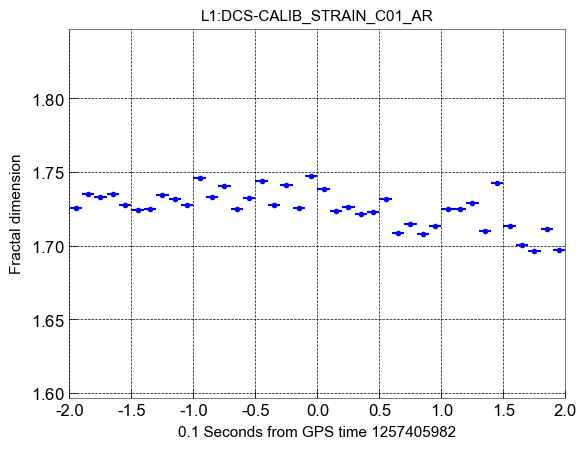

In [35]:
fig, ax = plt.subplots()
plot_min_y = data_fd['fd'].min() - 0.1
plot_max_y = data_fd['fd'].max() + 0.1

ax.set_title(channel, fontsize=11)
ax.tick_params(direction='in', length=6, width=0.5, colors='black', grid_color='r', grid_alpha=1)
ax.set_xlabel(f"{step} Seconds from GPS time {glitch_start_time}", fontsize=11)
ax.set_ylabel("Fractal dimension",fontsize=11)
ax.set_xlim([glitch_start_time,glitch_stop_time])
ax.set_ylim([plot_min_y, plot_max_y])
ax.set_xticks(np.linspace(glitch_start_time, glitch_stop_time, 9))
ax.set_xticklabels(np.linspace(-2, 2, 9))

ax.grid(which='both', axis='both', linestyle='--', color='k', linewidth=0.5)

time = data_fd['time'].values
step = time[1]-time[0]
fd = data_fd['fd'].values
ax.errorbar(time+step/2, fd, xerr=step/2, fmt='.', c='b')

## Calculate FD for all glitches in train_dir (H1 and L1)

In [11]:
filenames = []
with open("H1_glitches.txt", "r") as file:
    for line in file:
        filenames.append(line.strip())

In [12]:
def is_in_interval(number, interval_dataframe):
  """
  This function checks if a number falls within any of the intervals in a DataFrame.

  Args:
      number: The number to check.
      interval_dataframe: A DataFrame with two columns, 'start' and 'stop', representing the intervals.

  Returns:
      A boolean value indicating whether the number falls within any interval (True) or not (False).
  """
  return (interval_dataframe[0] <= number) & (number <= interval_dataframe[1]).any()

In [14]:
glitch_segments_H1 = []
gsH1 = pd.read_csv("Data/H1-SEGS-AUX_CLN.csv", header=None)

In [ ]:
for fn in filenames:
    glitch_id = str(fn)
    peak_time = O3b_csv[O3b_csv.id == glitch_id]['GPStime']
    if not peak_time.empty:
        start = int(peak_time)-2
        tmp1 = is_in_interval(start, gsH1)
        if tmp1.any():
            stop = int(peak_time)+2
            tmp2 = is_in_interval(stop, gsH1)
            if tmp2.any():
                print(f"FD calculation for {glitch_id} has started.")
                data_fd = my_gwpy_and_fractals.calculate_fd_files(start, stop, server, sampling_rate, channel, step, decimate, alpha, False)
                if data_fd is not None:
                    filename = "FD_data/fd_calculation_" + glitch_id + "_aux_channel_" + channel.replace(':', '_') + ".txt"
                    data_fd.to_csv(filename, sep='\t', index=False)
                else:
                    print('No fd calculations made because no data available')
            else:
                print(f"{stop} does not fall within any of the intervals")
        else:
          print(f"{start} does not fall within any of the intervals")
    else:
        print(f"Error with the glitch labeled {glitch_id}")

## Plot all FD's for CALIB_STRAIN from L1

In [27]:
L1_valid_selection = "L1_valid_glitches.txt"
fd_Dir = "FD_data"

valid_glitch_names_L1 = set()

for root, _, files in os.walk(fd_Dir):
    for filename in files:
        if filename.startswith("fd_") and filename.endswith("L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt"):
            parts = filename.split("_")
            if len(parts) >=3:
                valid_glitch_names_L1.add(parts[2])


In [28]:
with open(os.path.join(current_dir, L1_valid_selection), "w") as output_file:
    for name in valid_glitch_names_L1:
        output_file.write(f"{name}\n")

FD_data/fd_calculation_etWo3wFERt_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_Svkmehsdrq_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_60jxrIljdB_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_XGhQppSCaH_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_Yl2KkTaZBR_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_bjQ6r2BF3v_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_LjhTKQhxCI_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_cF4h1P2LD6_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_u8EcqxOdt4_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_HINif3dGlA_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_NiaqY1hBUw_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_4MhynYsMAt_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt
FD_data/fd_calculation_B7HqsNkc7i_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt

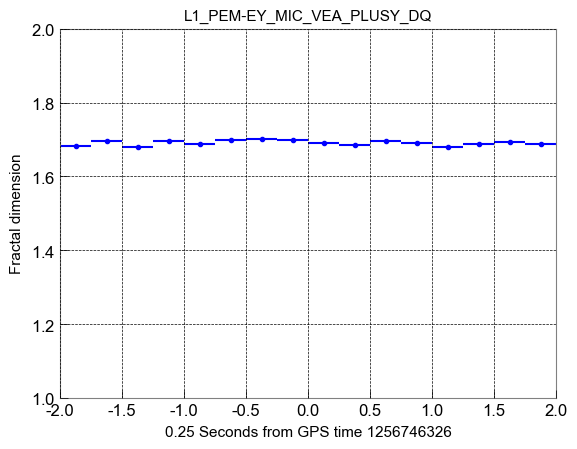

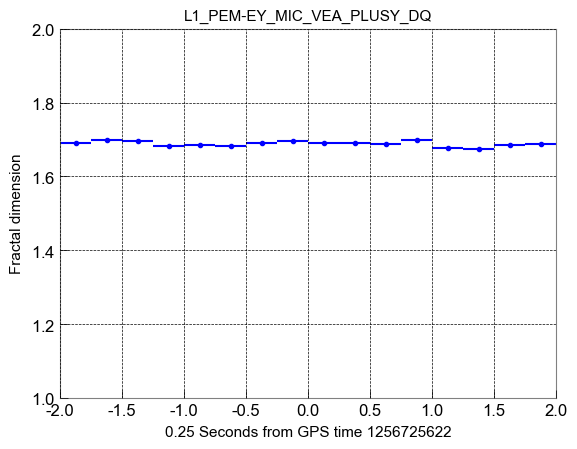

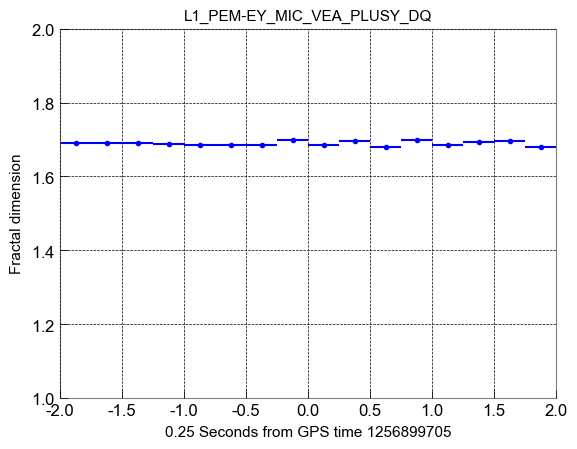

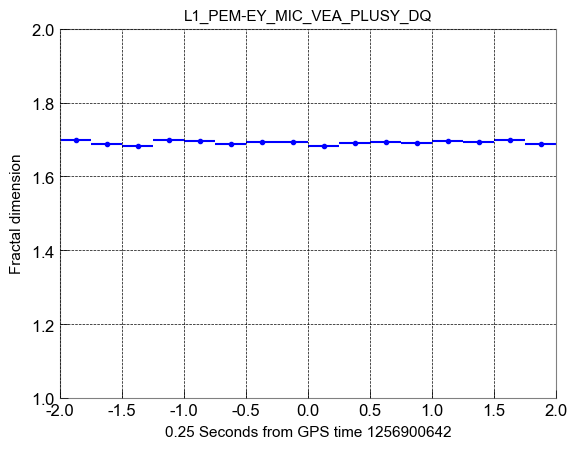

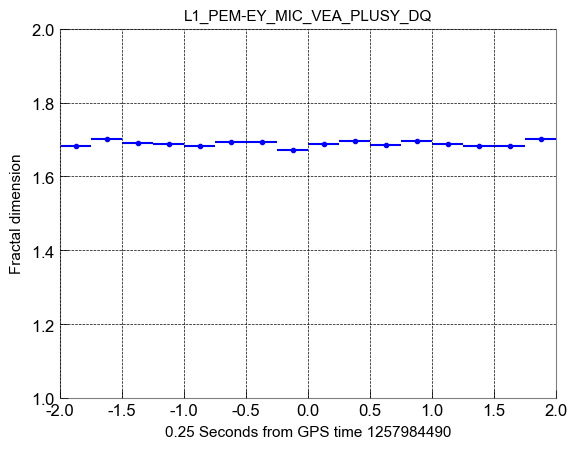

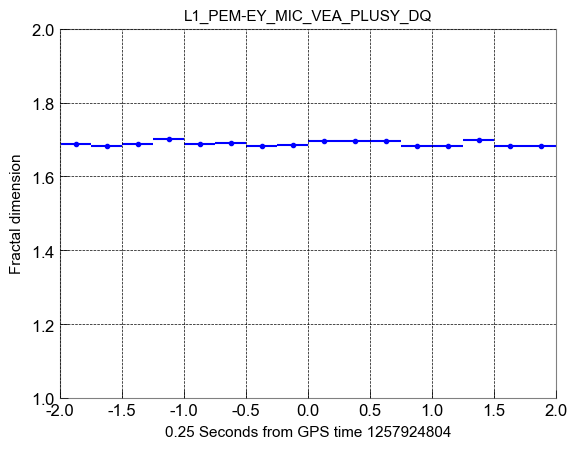

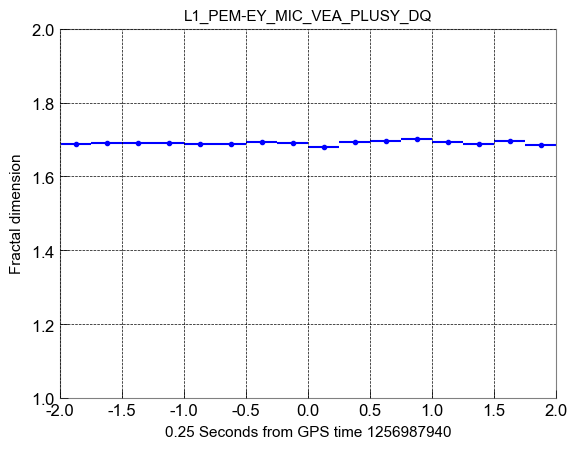

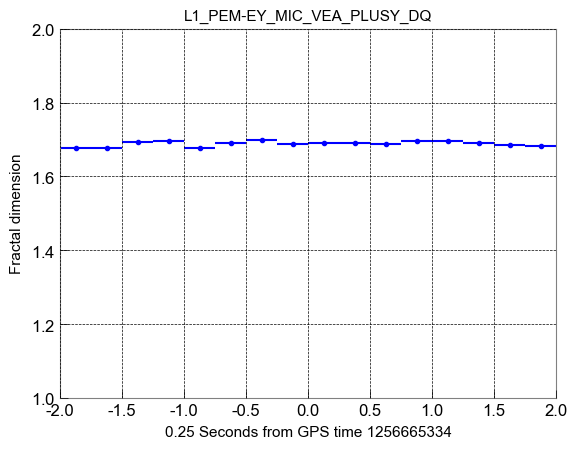

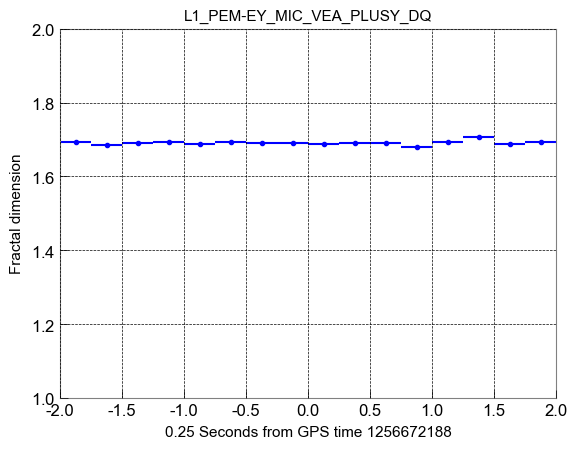

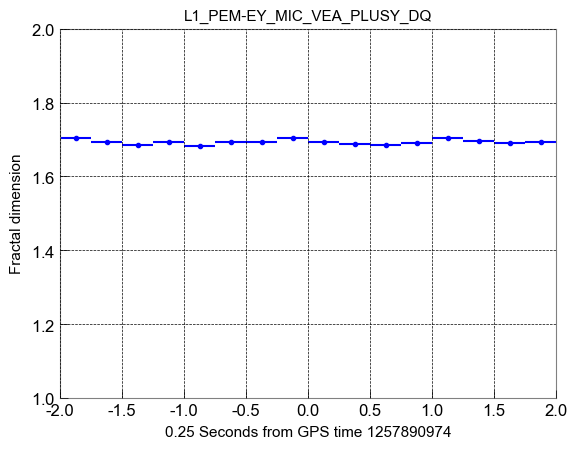

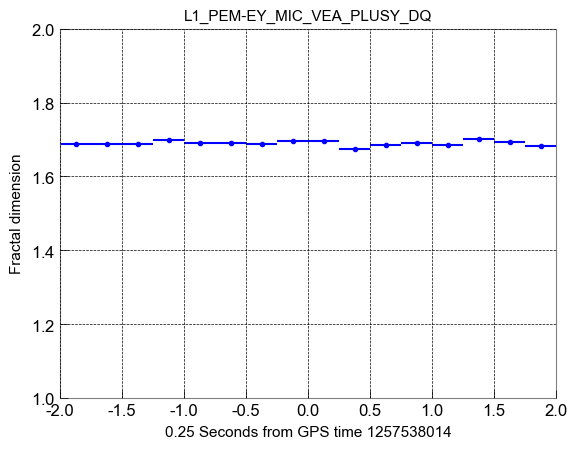

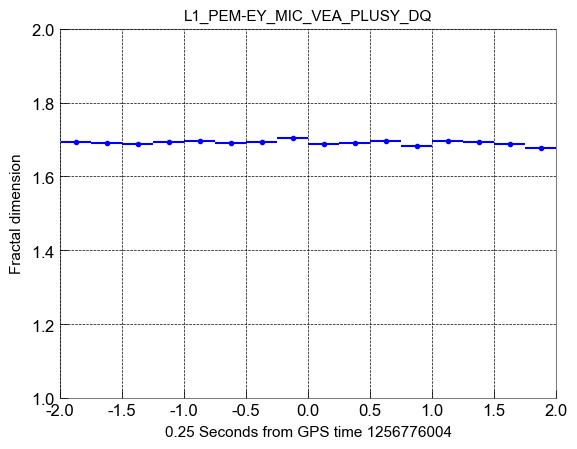

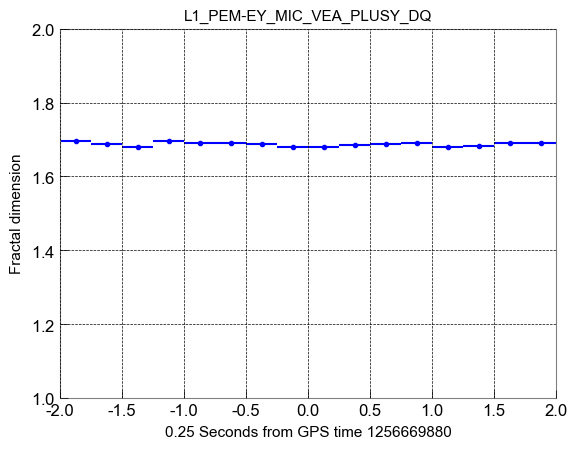

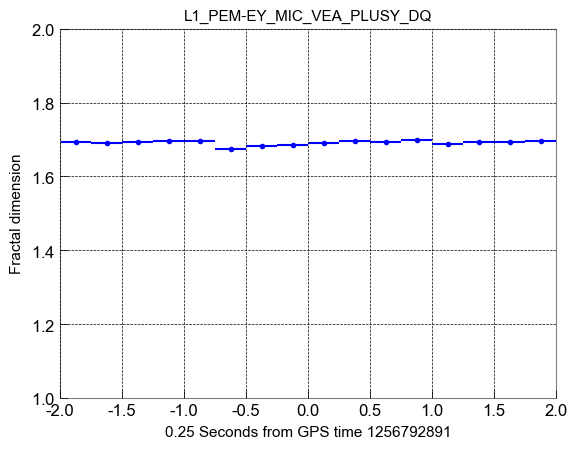

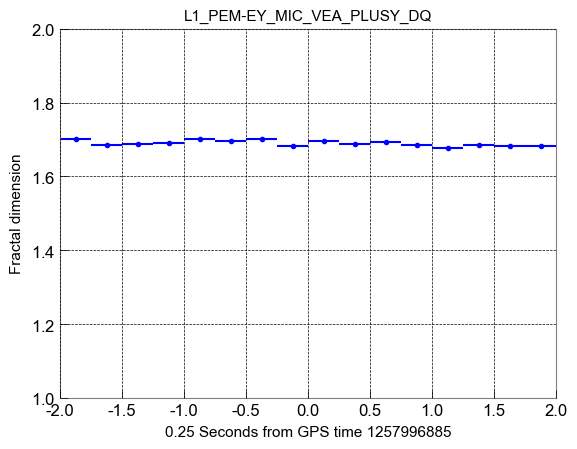

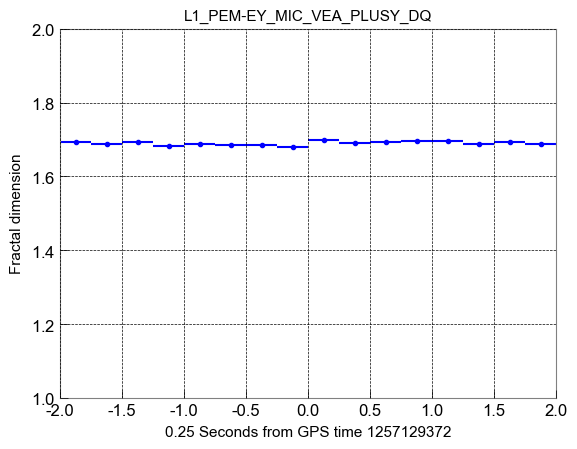

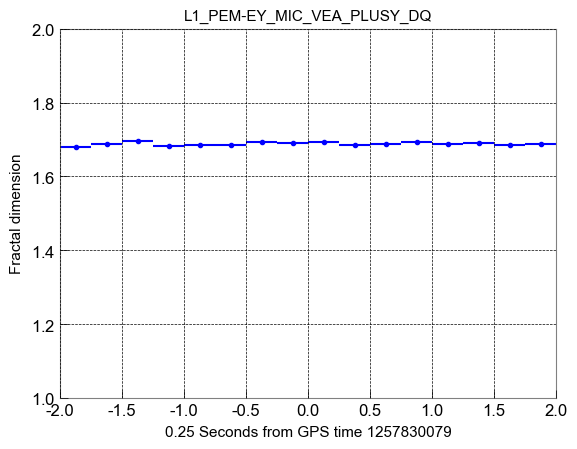

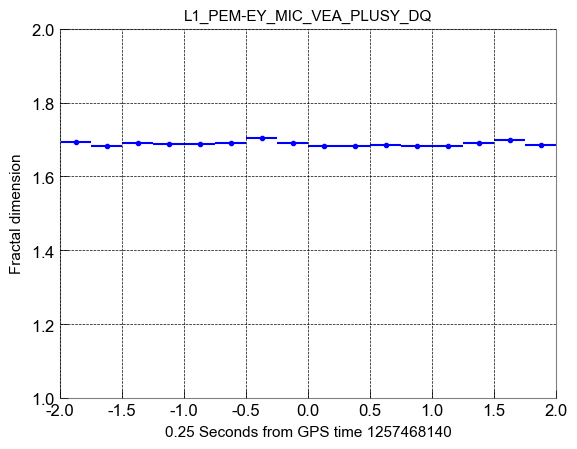

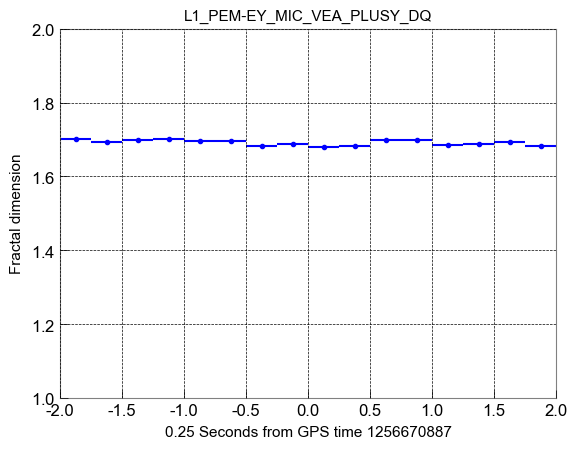

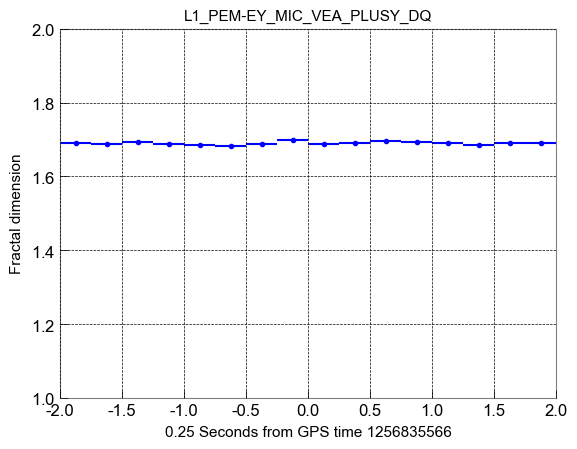

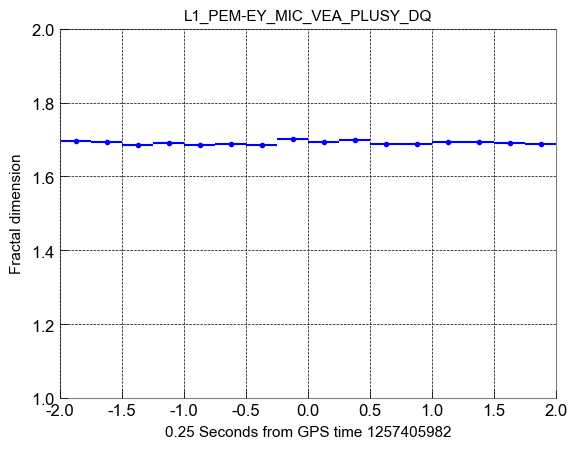

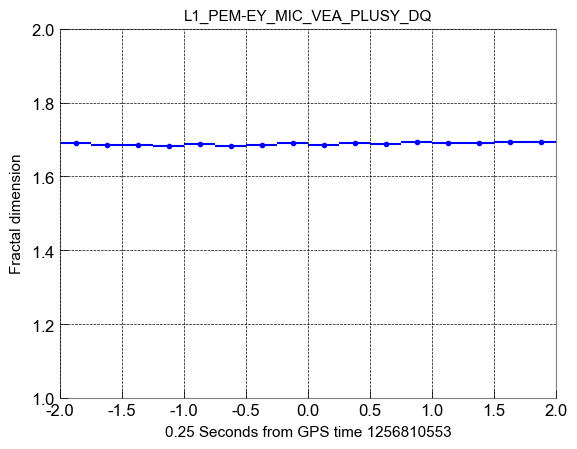

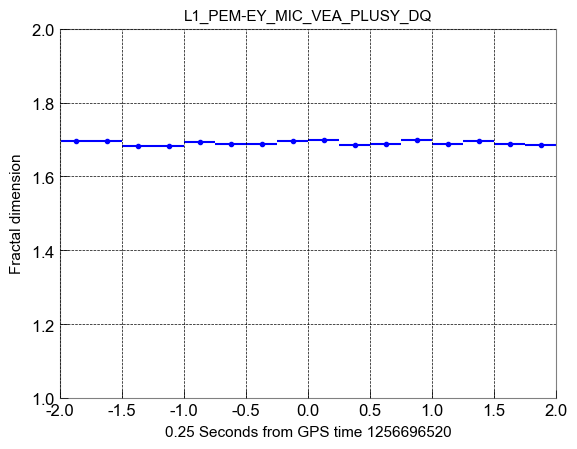

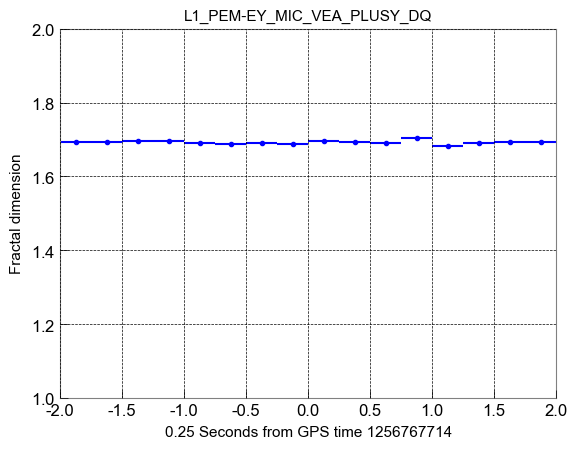

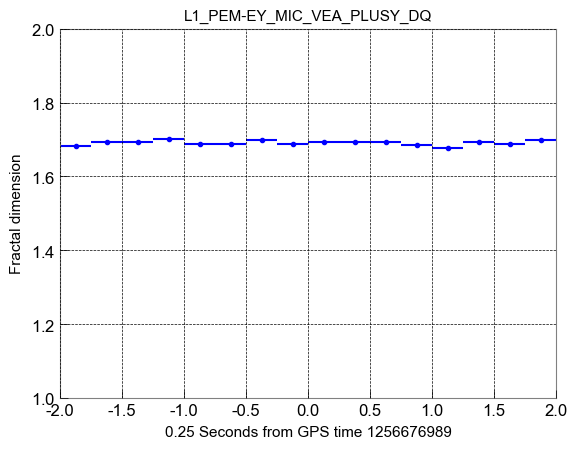

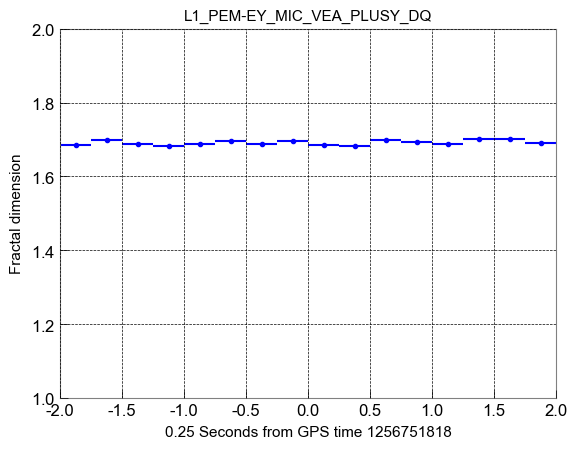

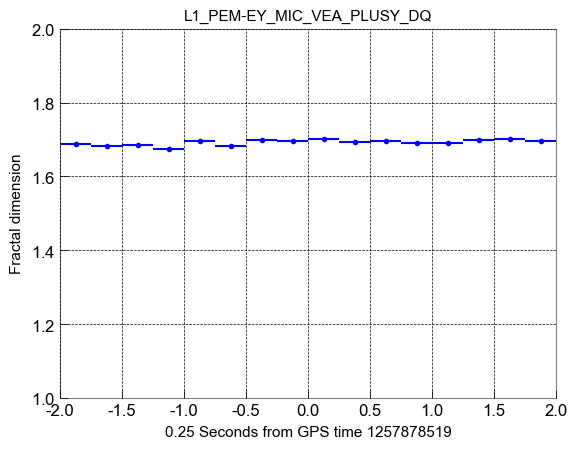

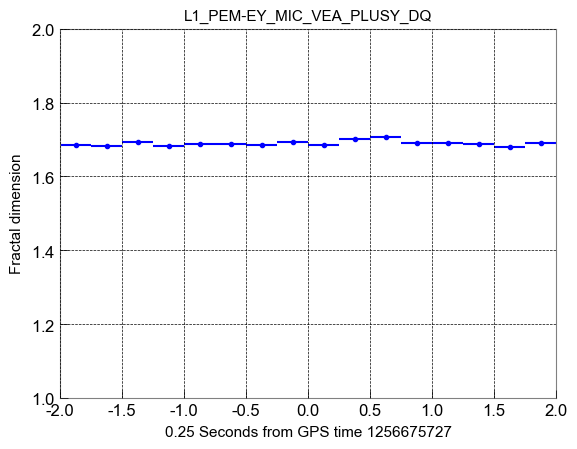

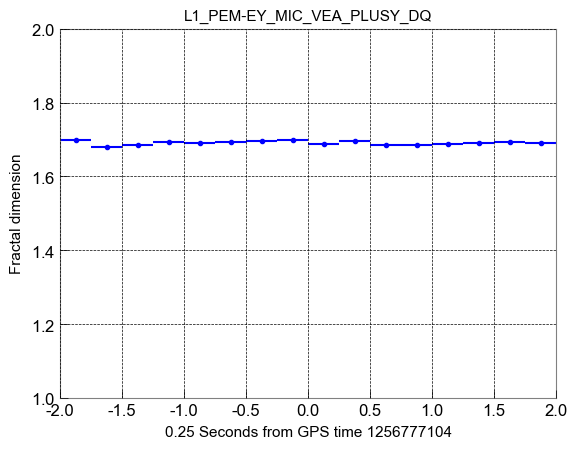

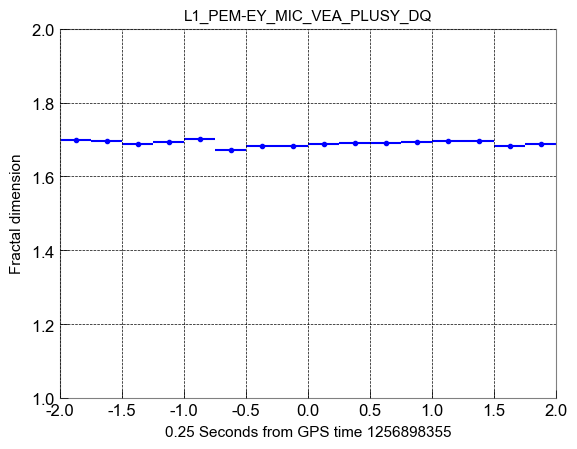

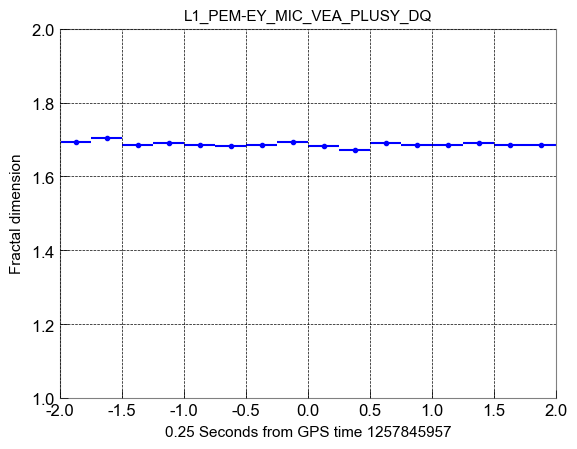

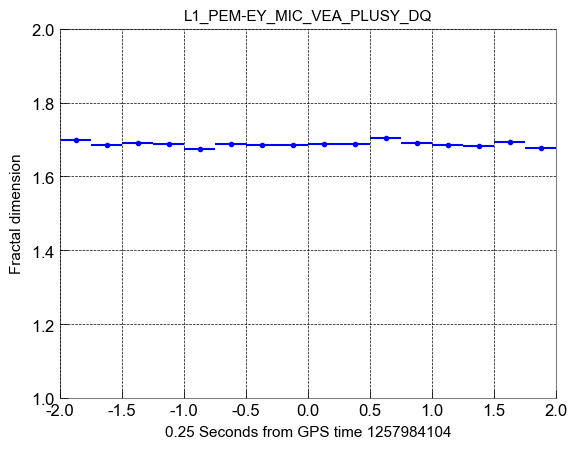

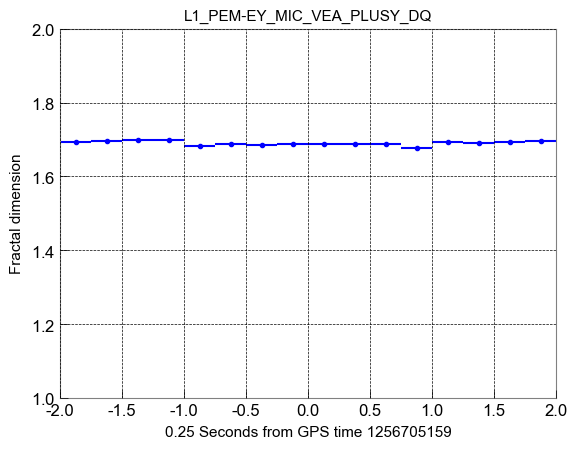

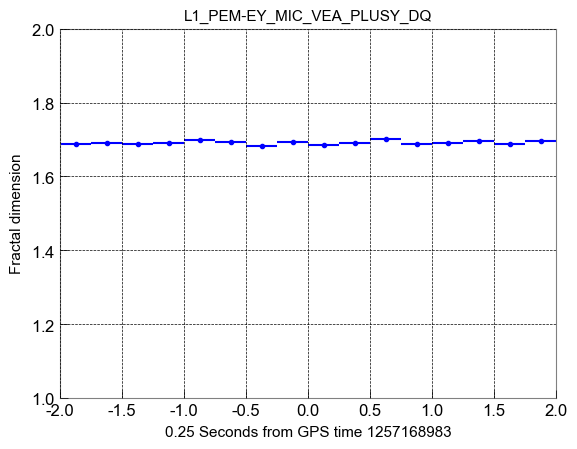

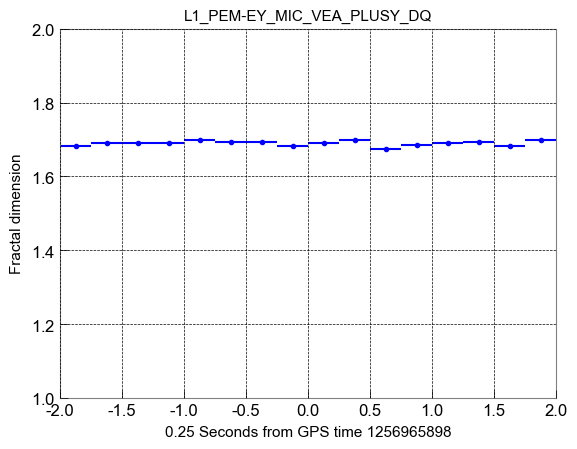

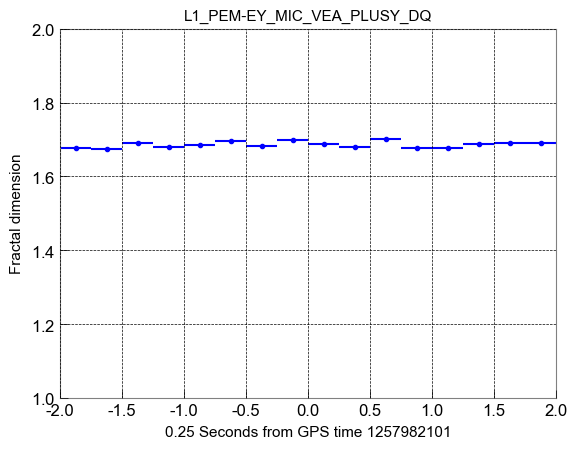

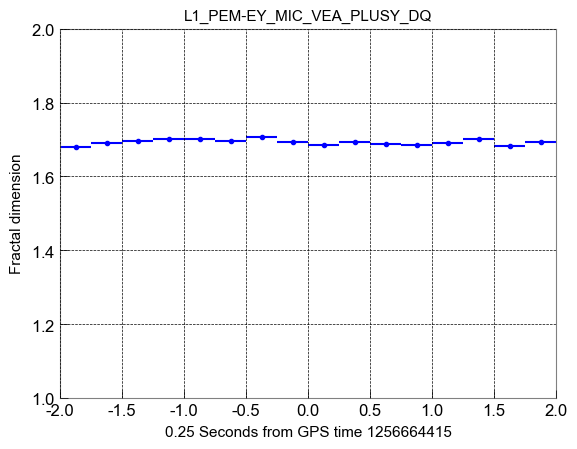

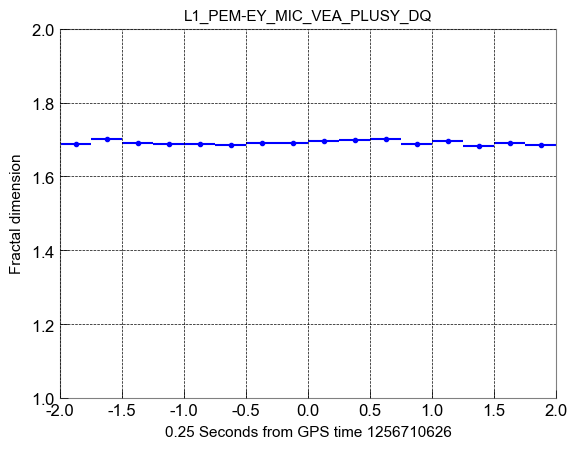

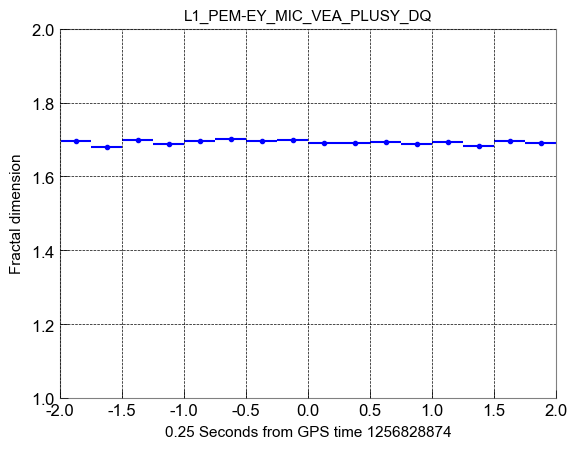

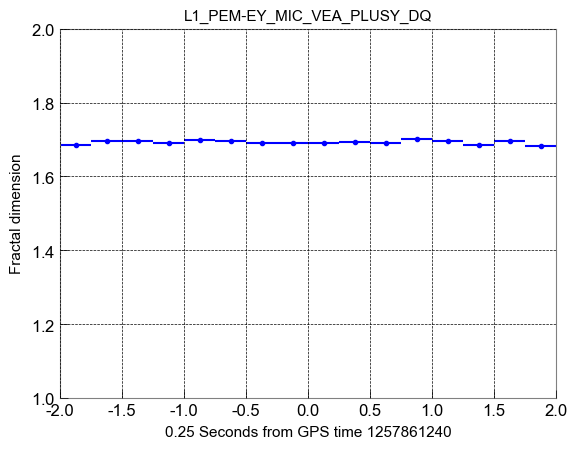

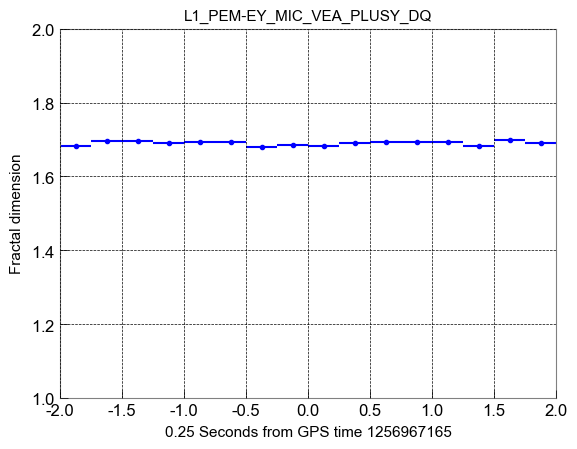

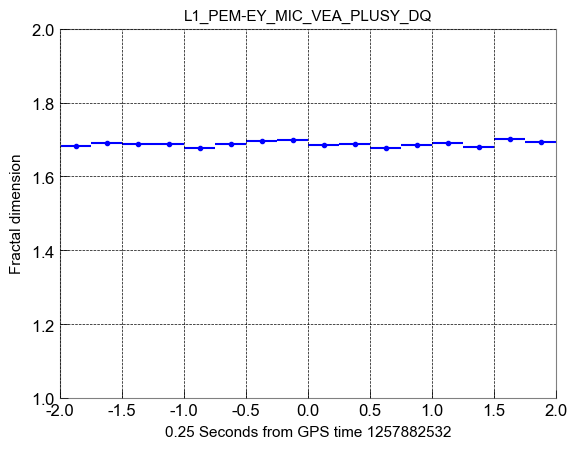

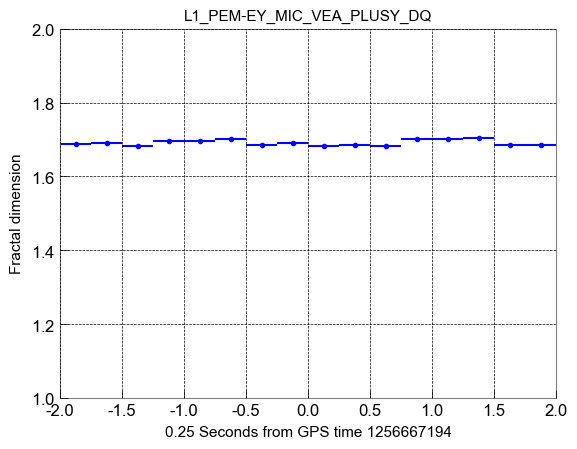

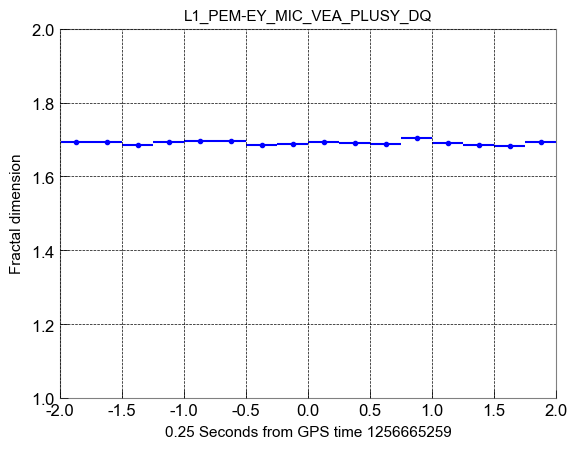

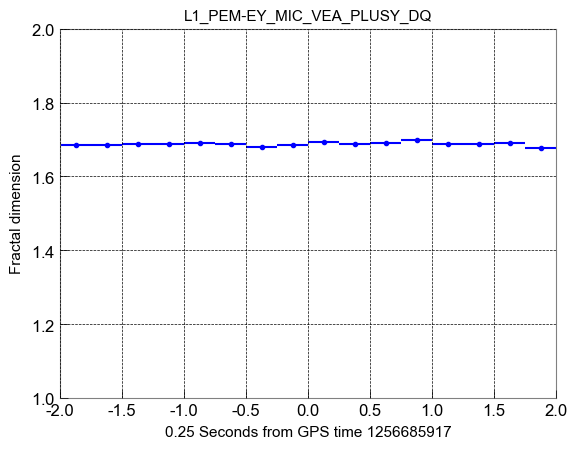

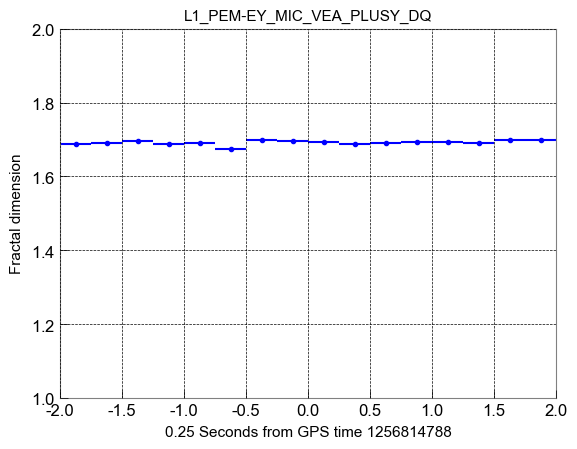

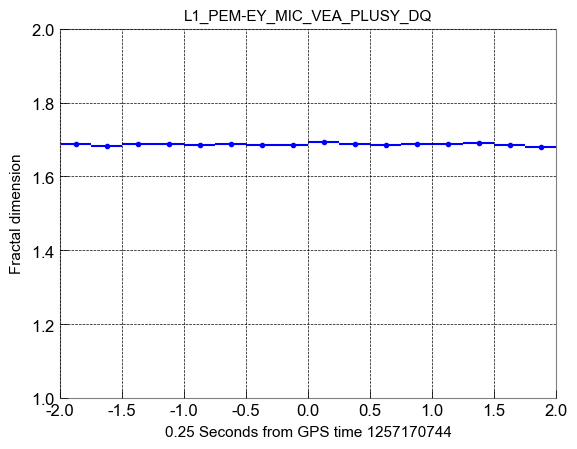

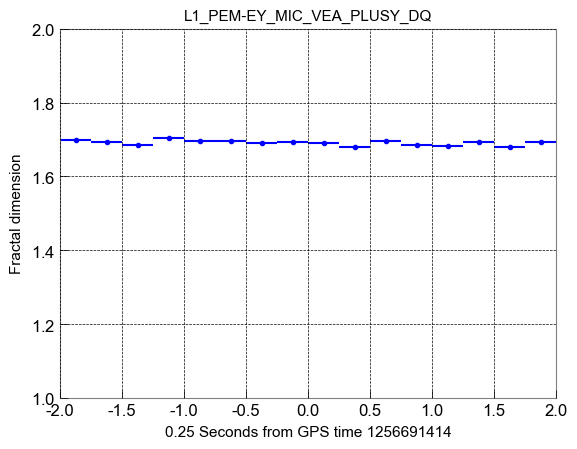

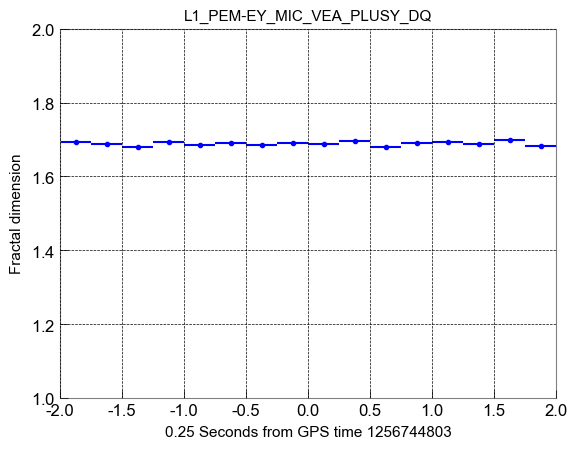

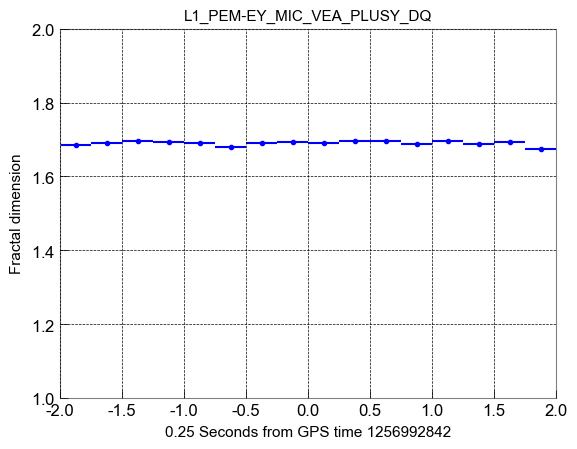

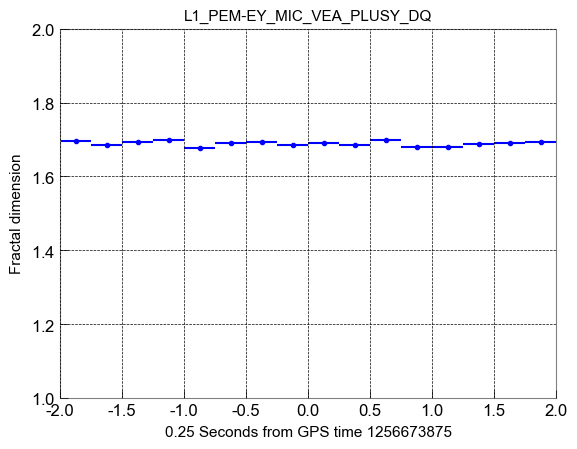

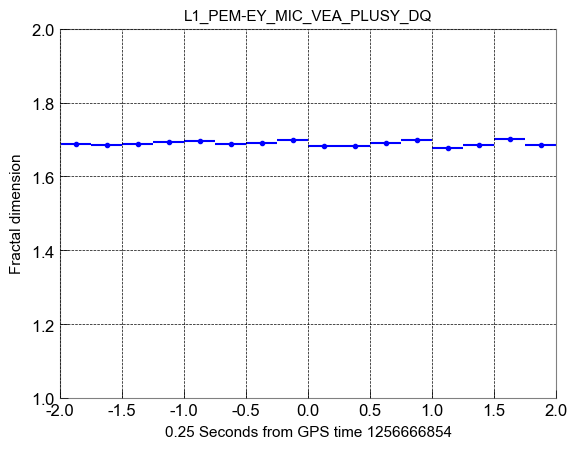

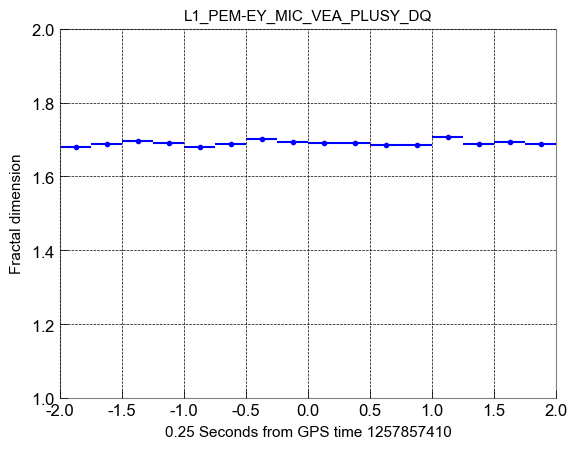

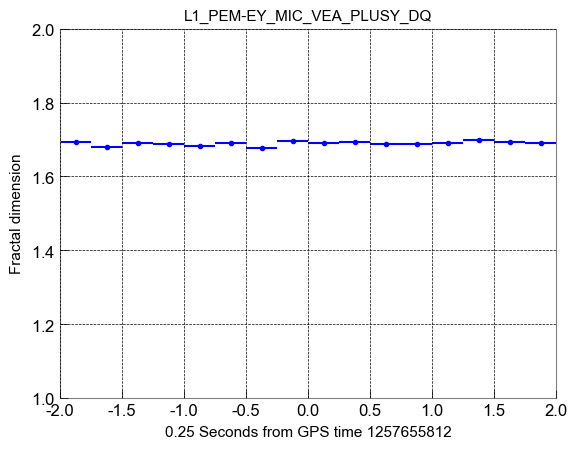

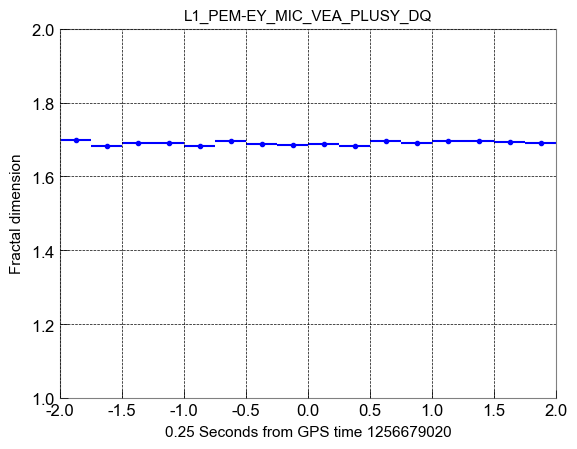

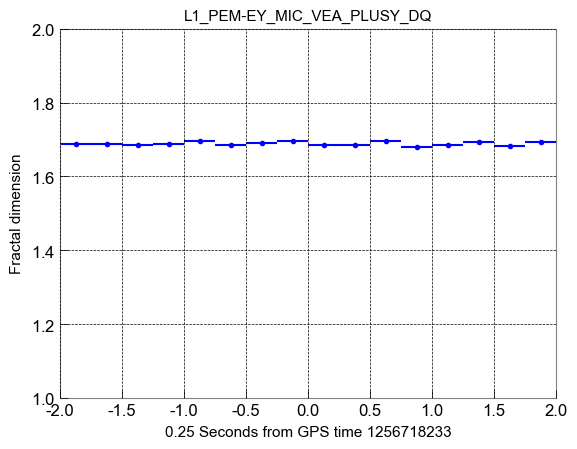

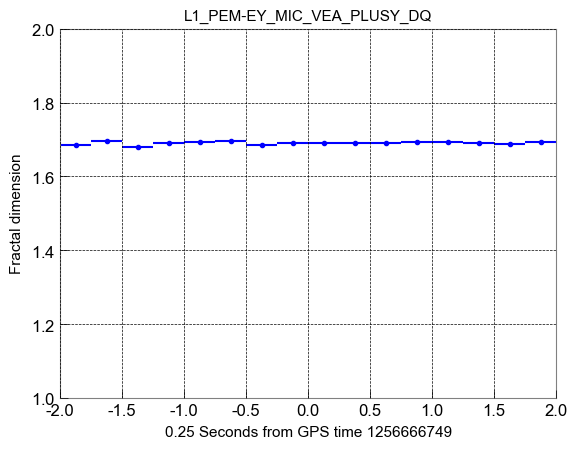

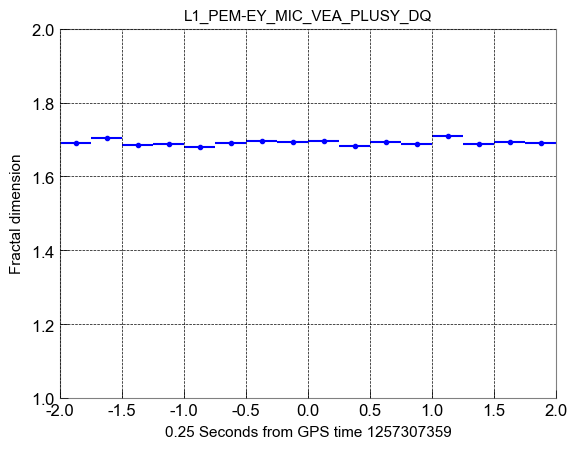

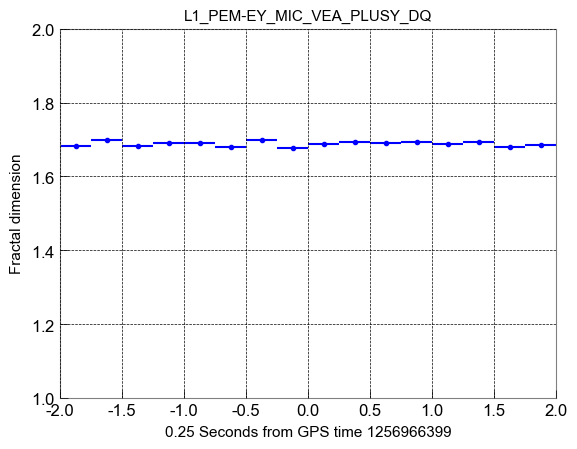

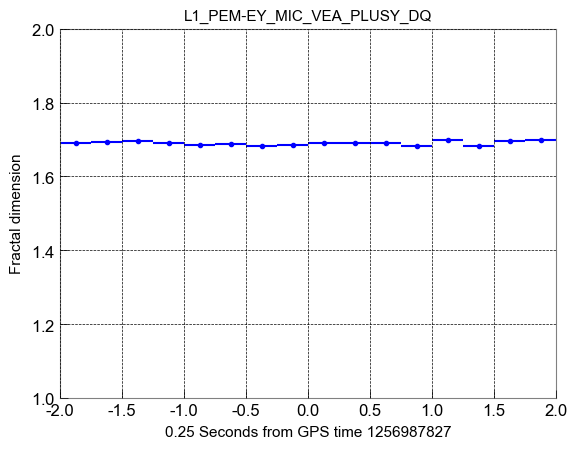

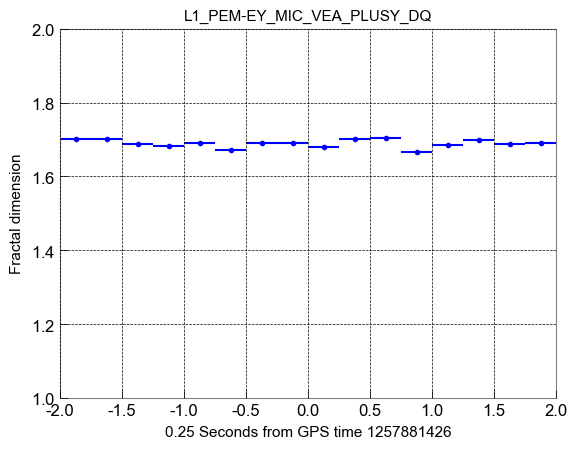

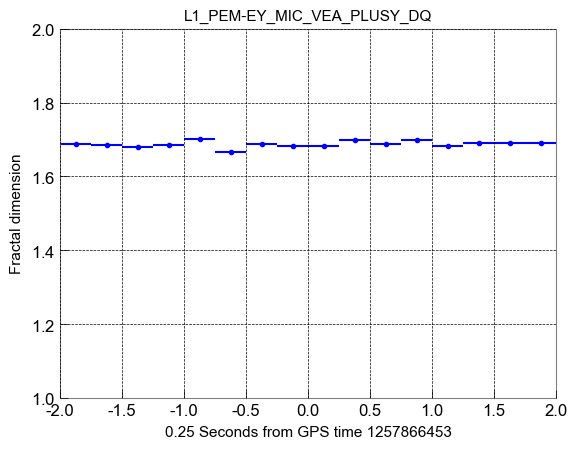

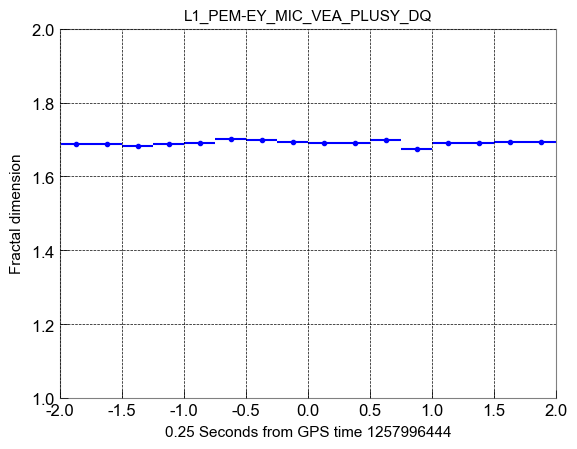

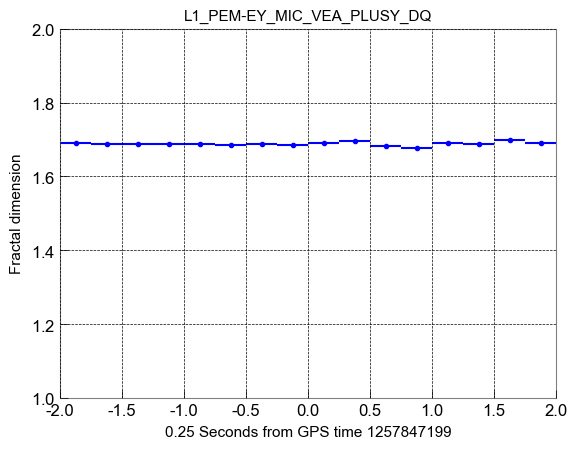

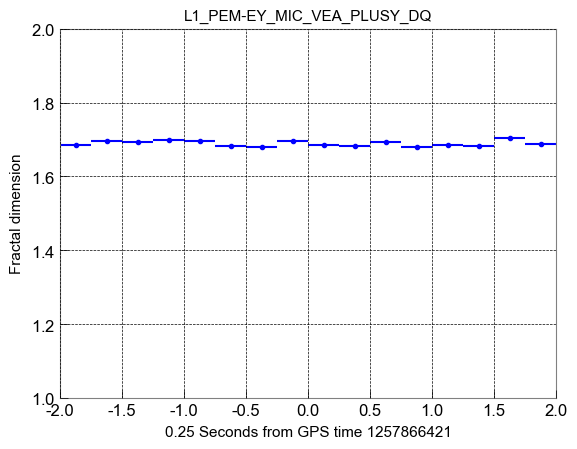

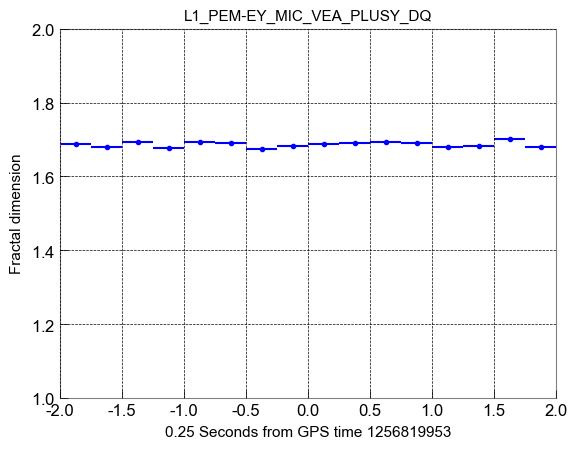

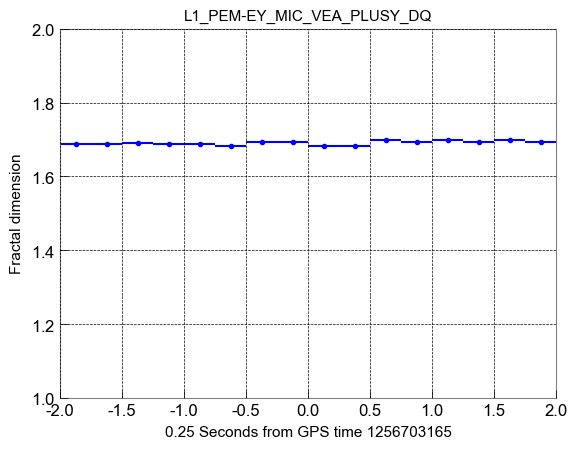

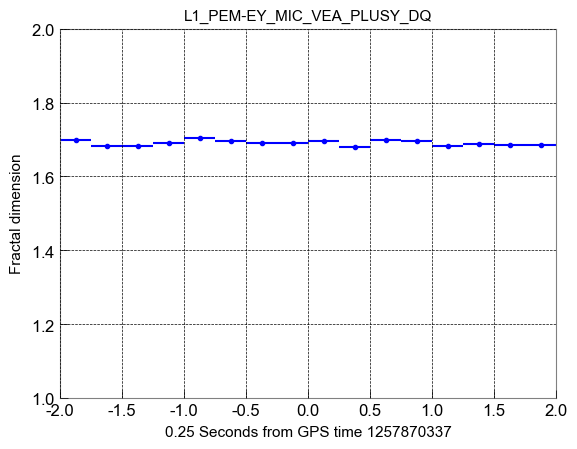

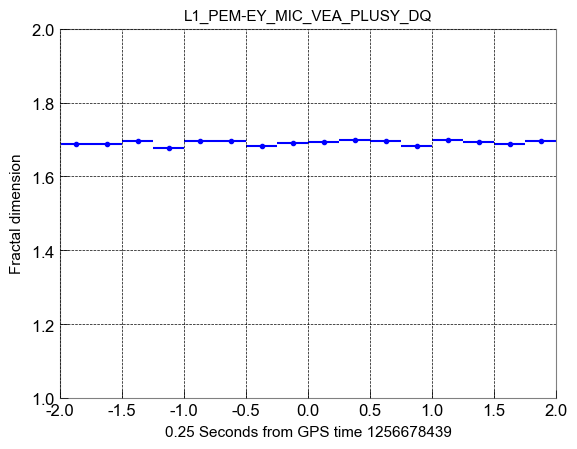

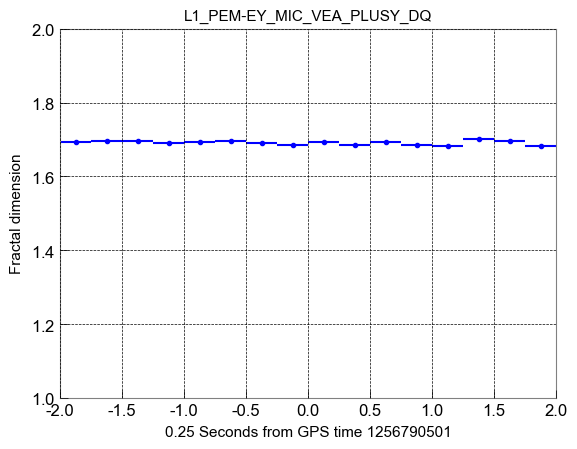

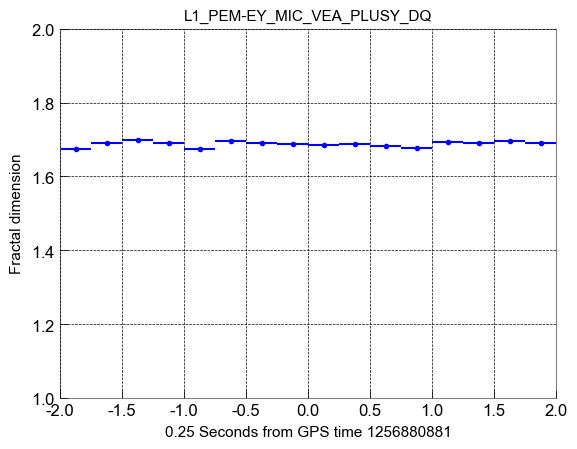

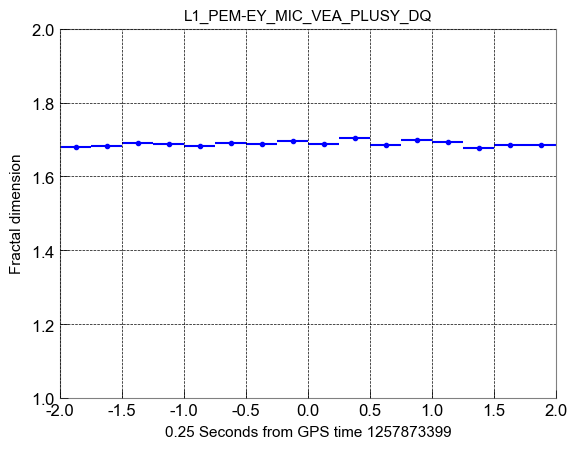

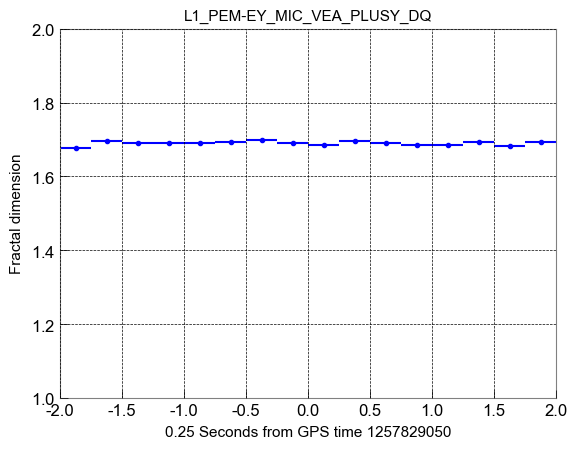

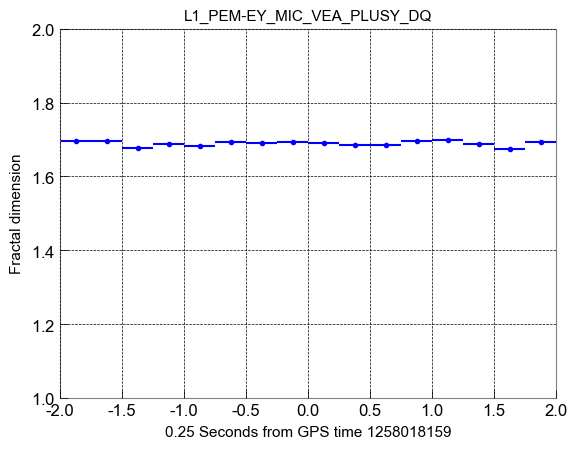

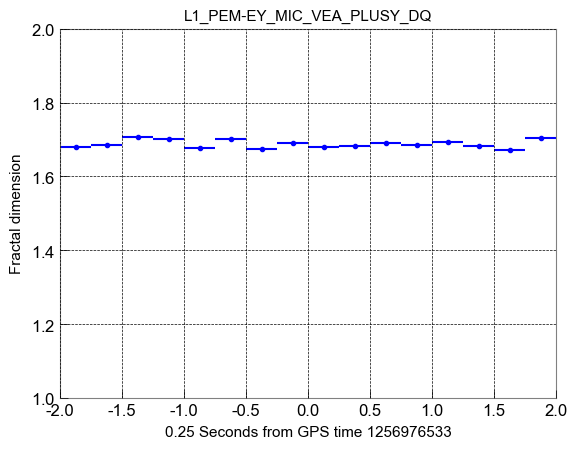

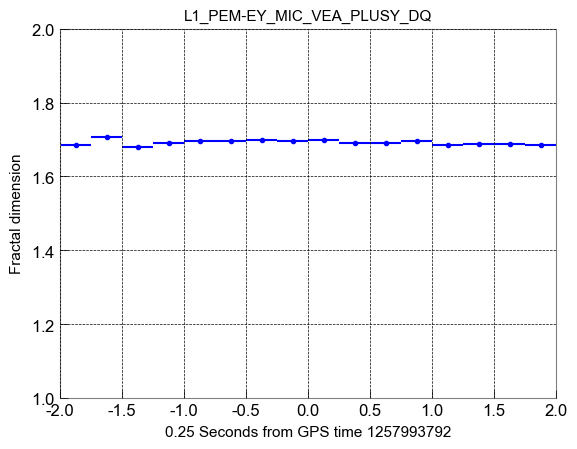

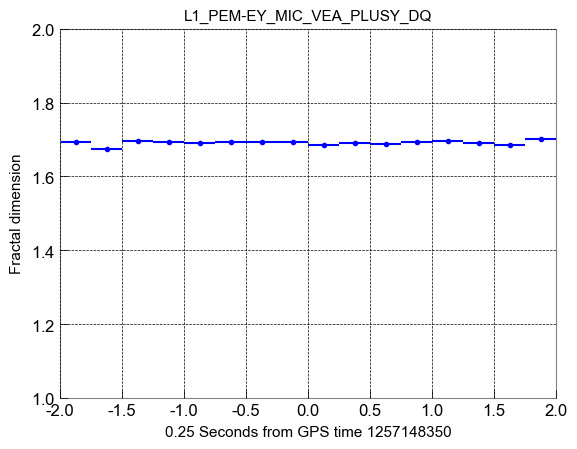

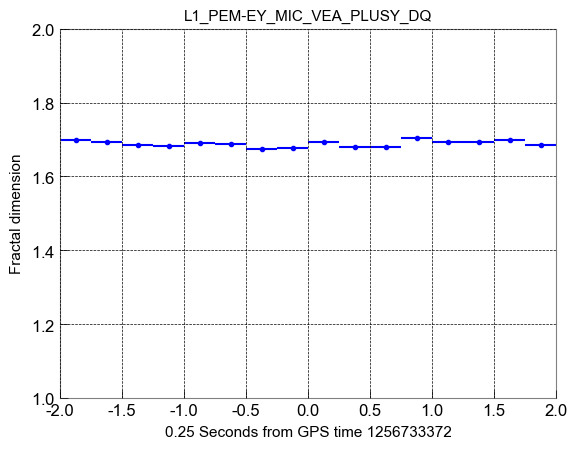

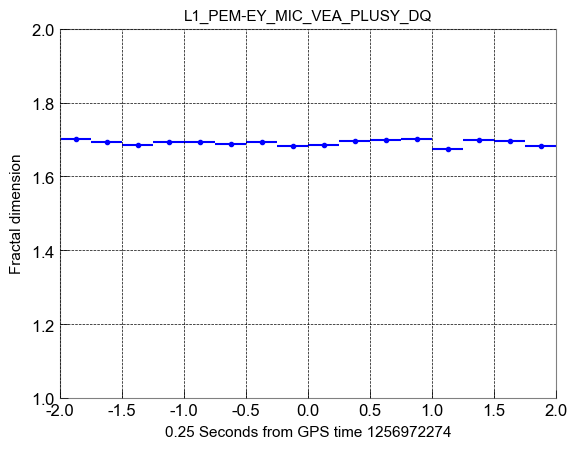

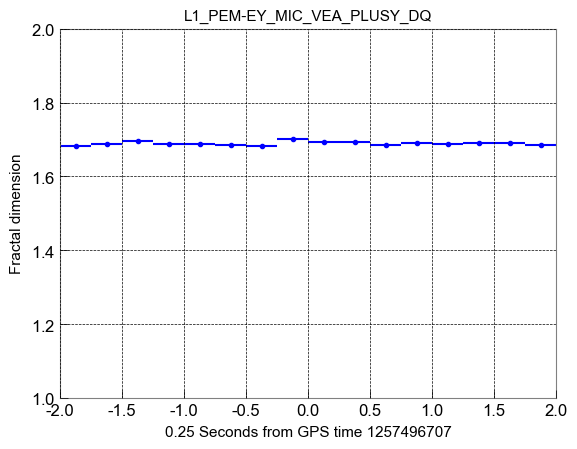

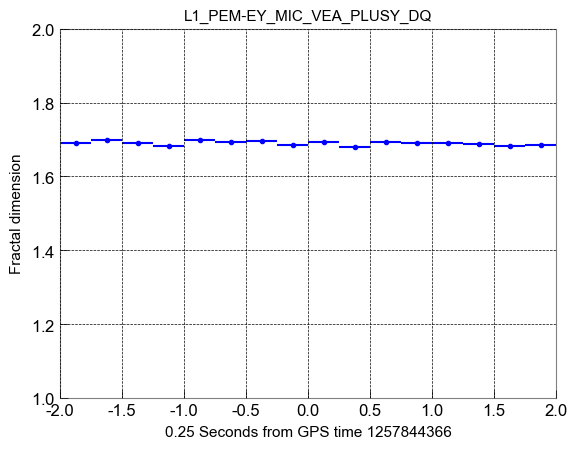

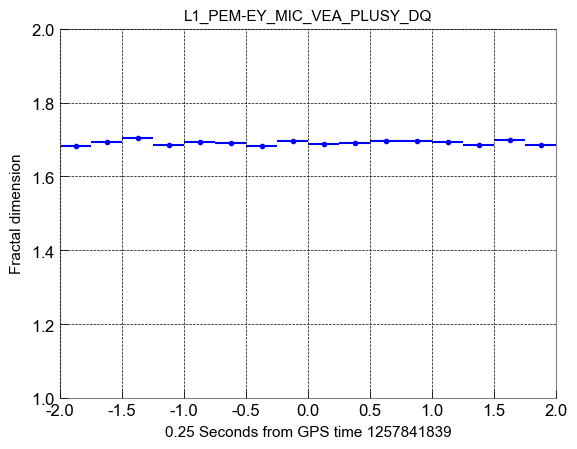

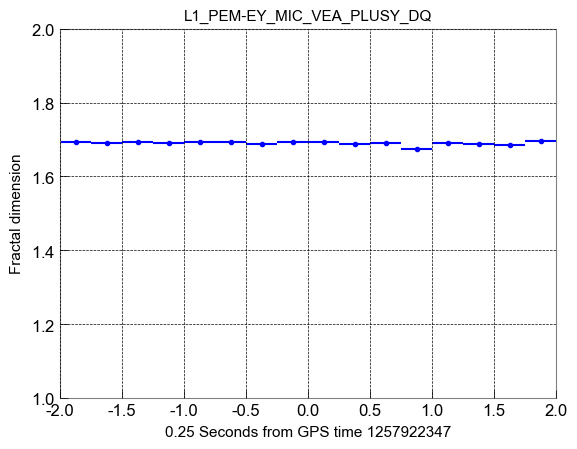

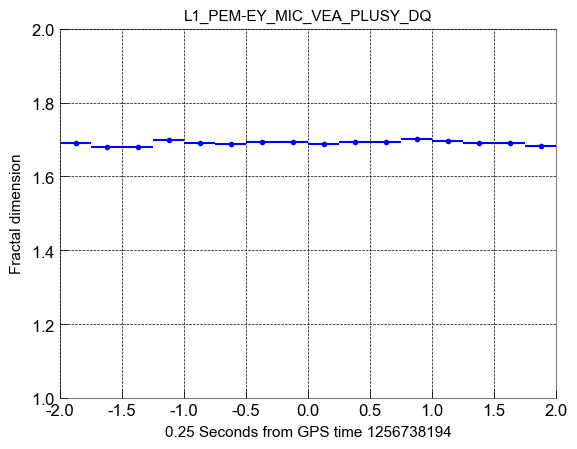

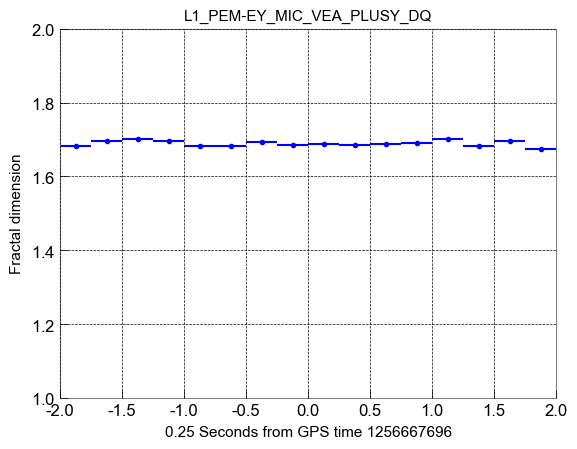

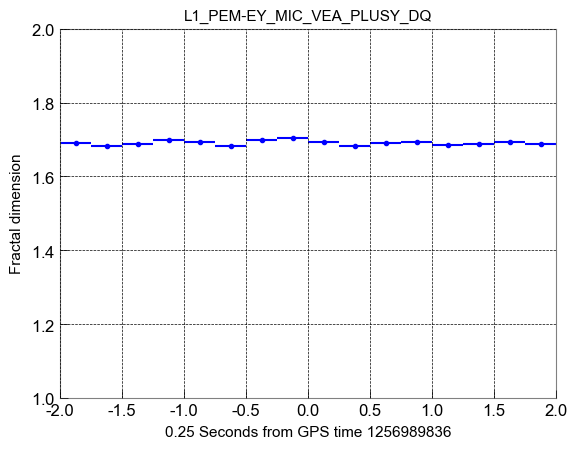

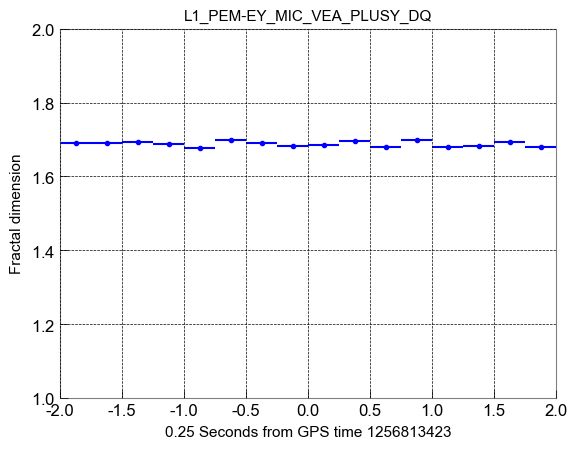

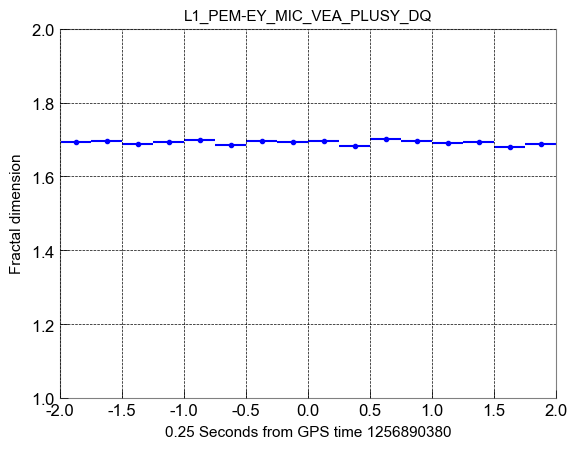

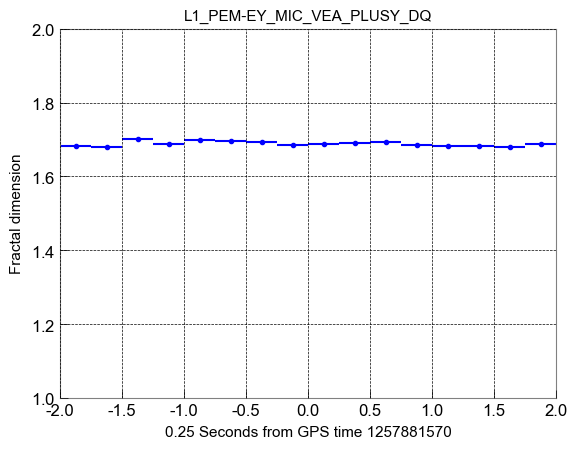

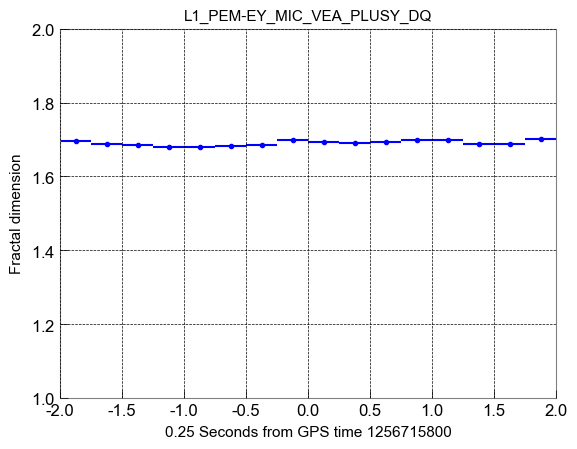

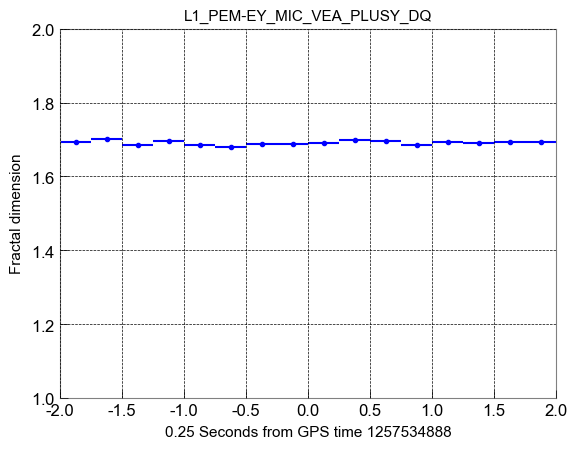

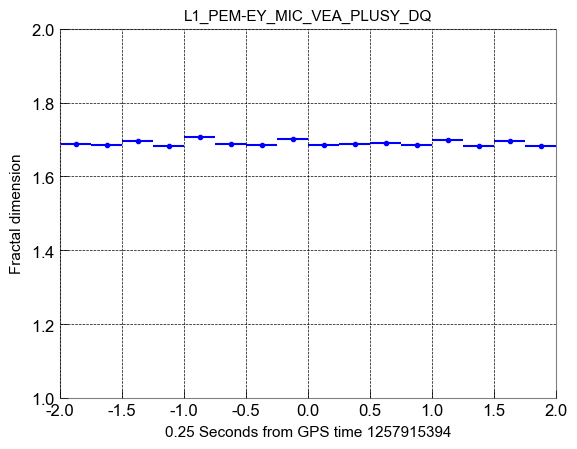

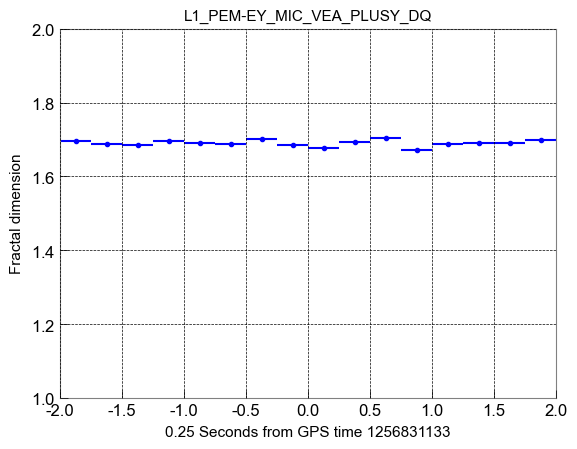

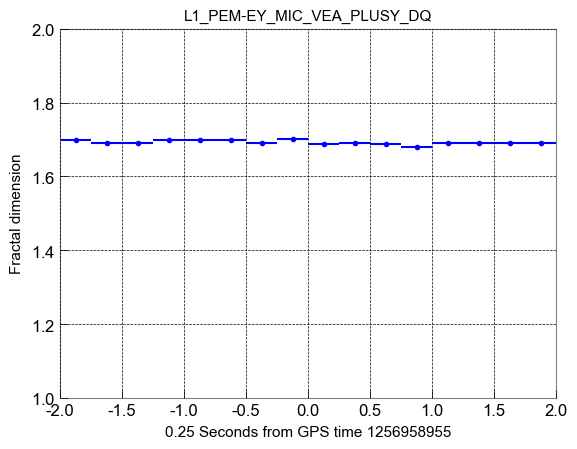

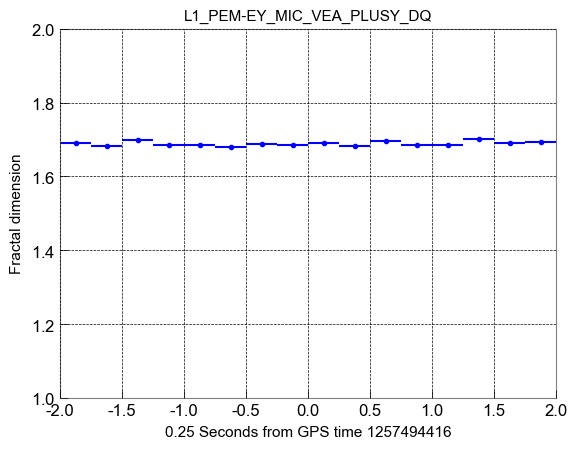

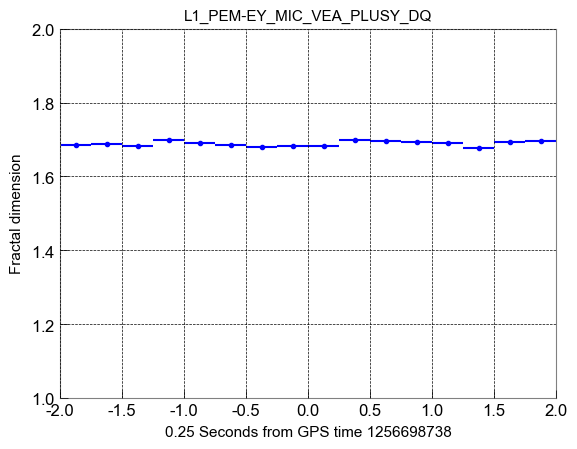

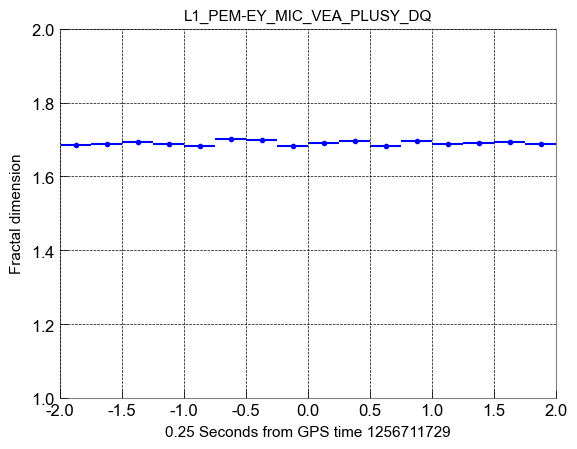

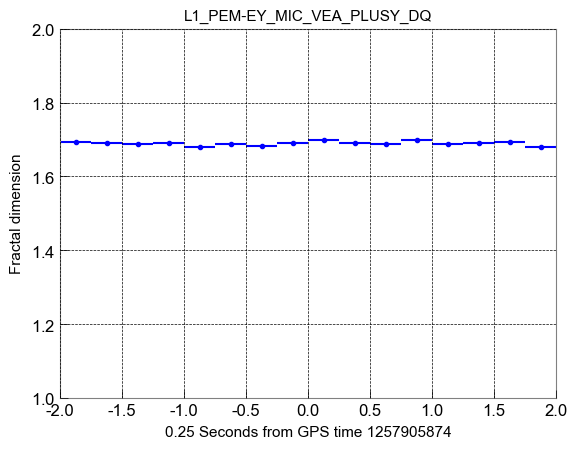

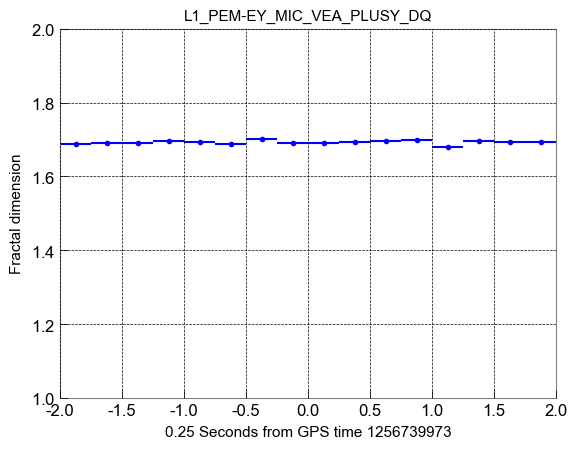

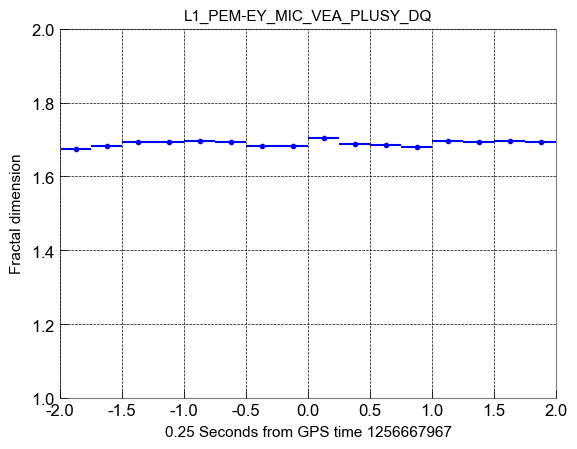

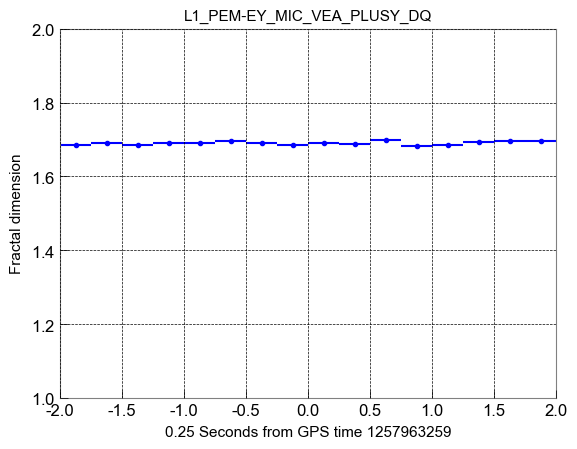

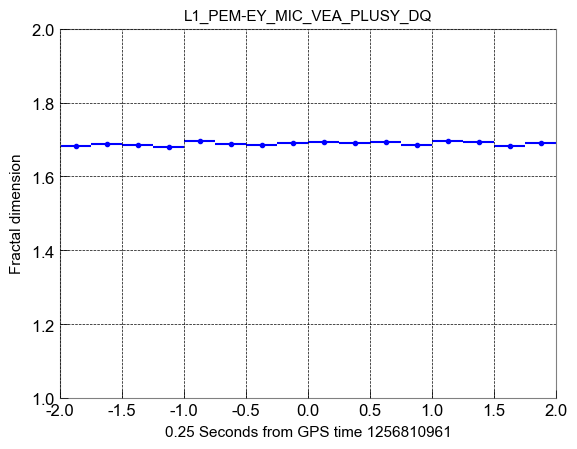

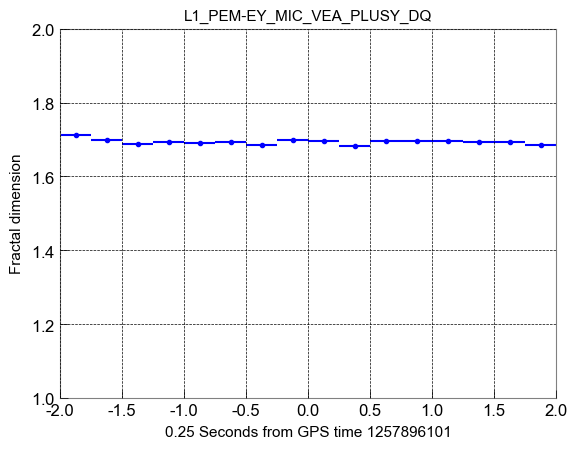

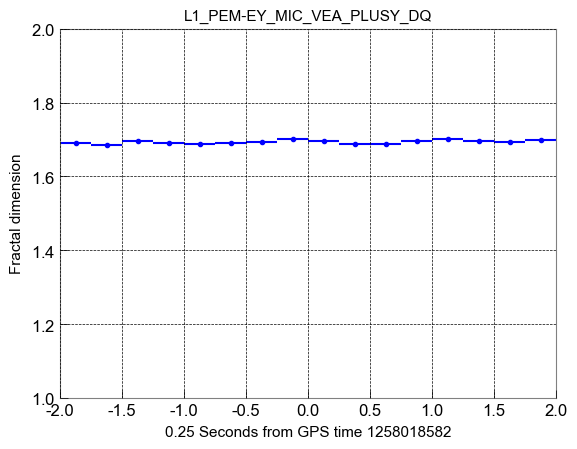

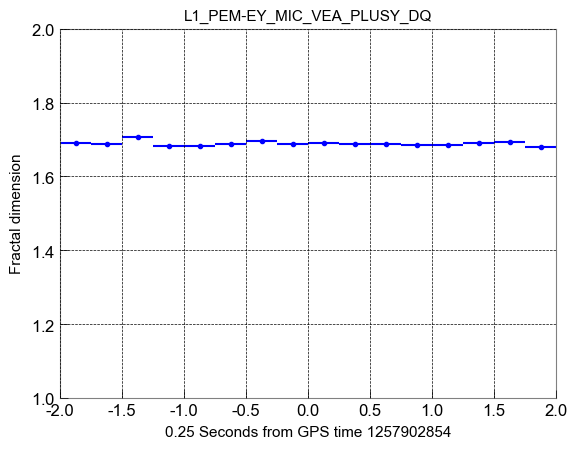

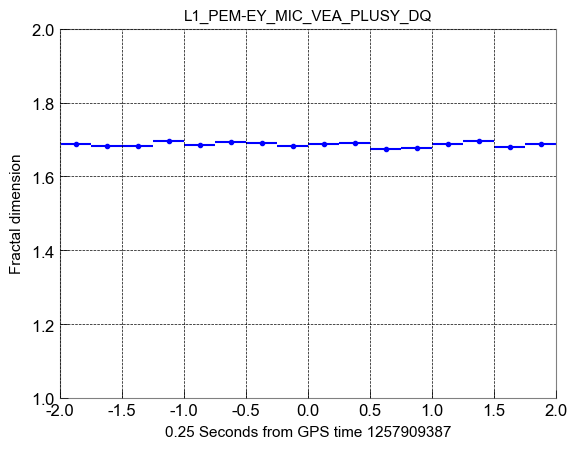

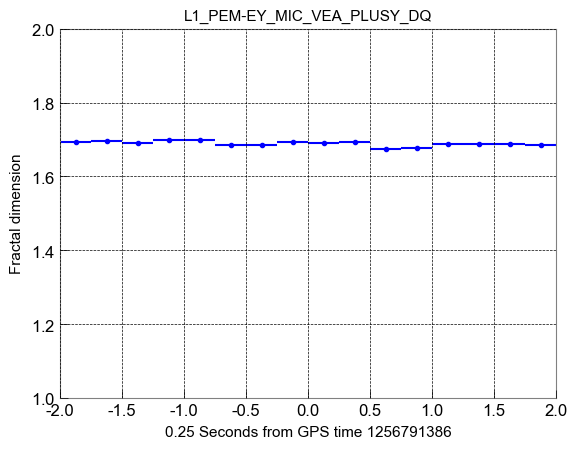

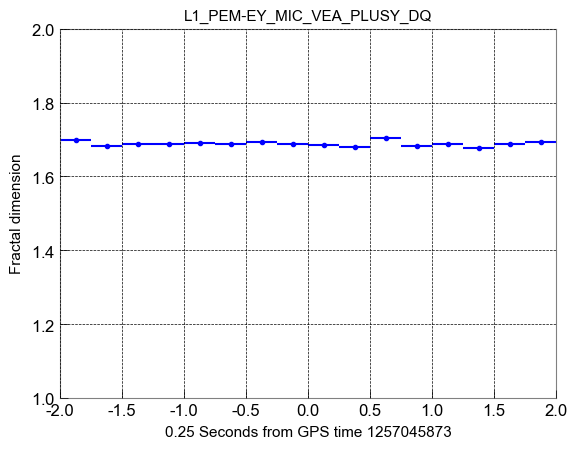

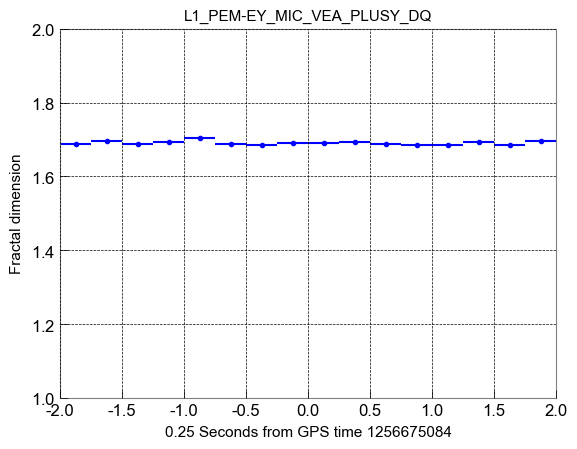

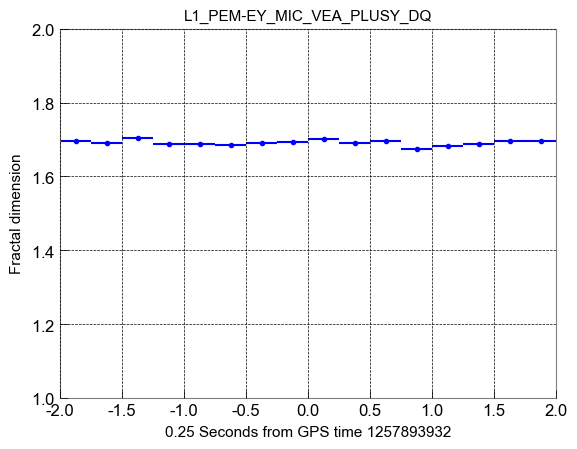

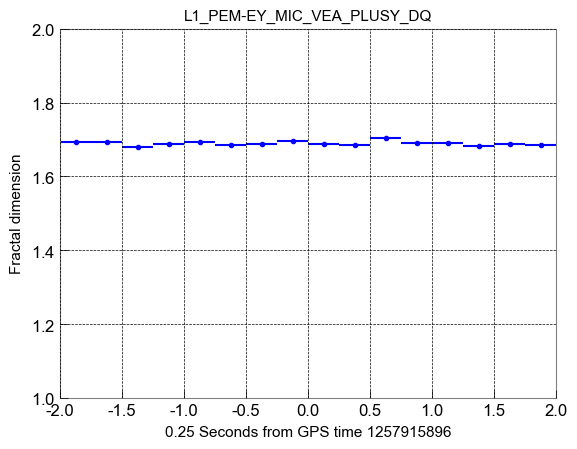

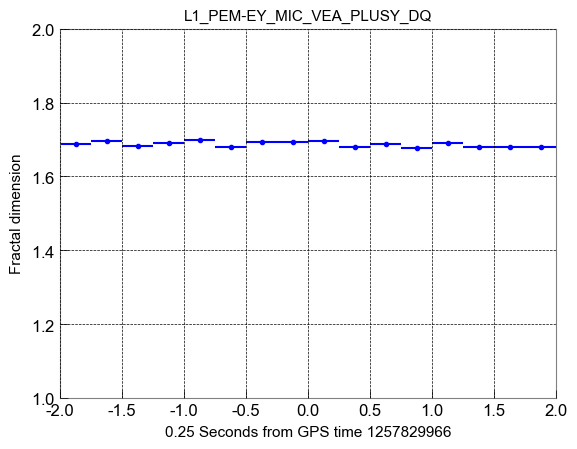

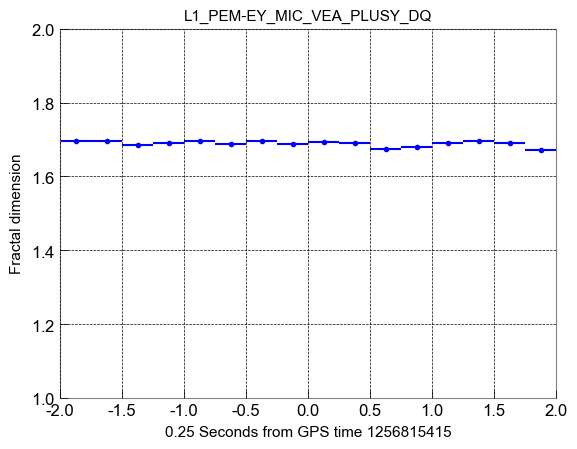

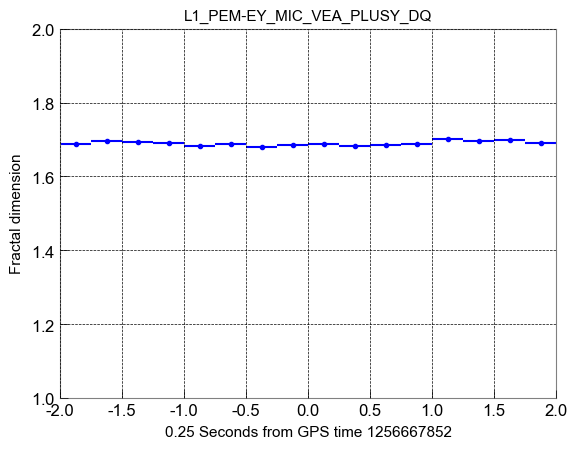

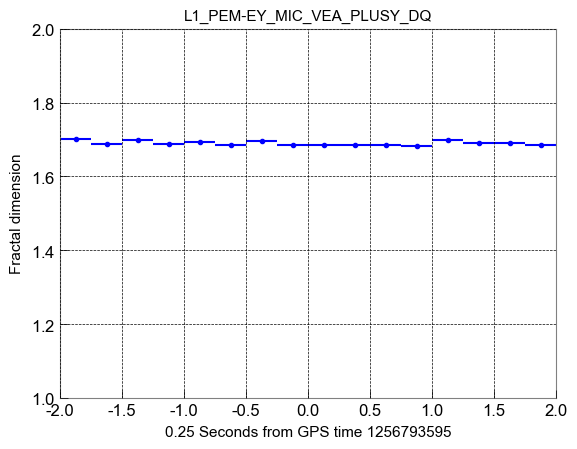

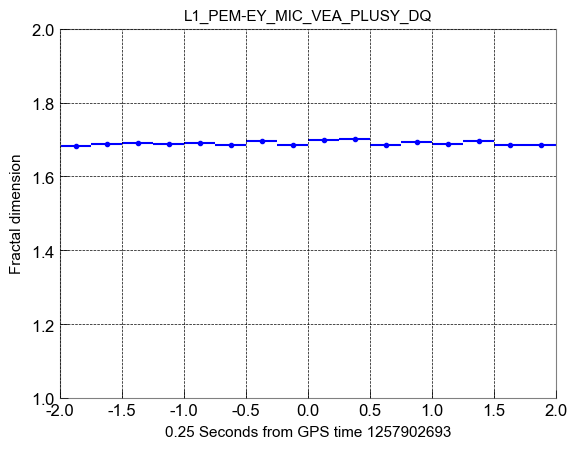

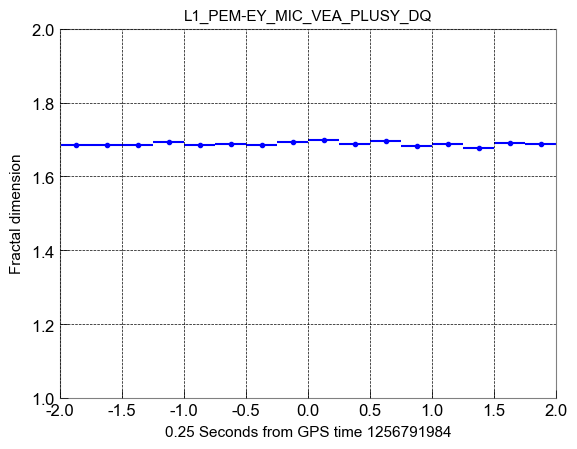

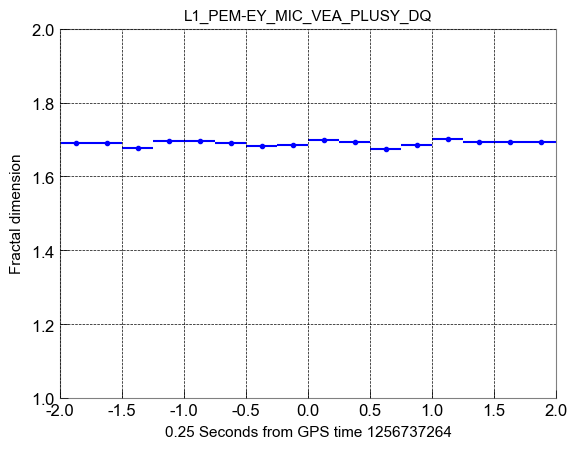

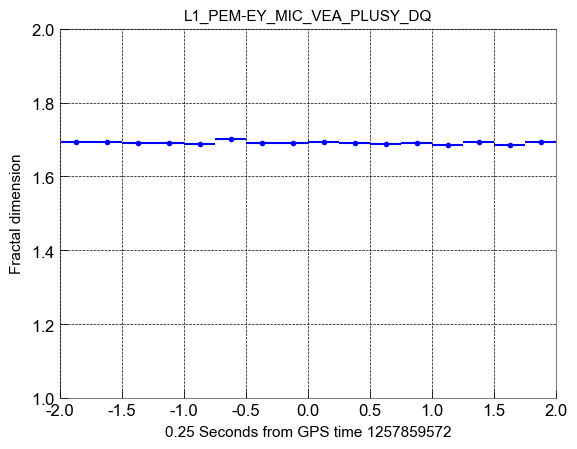

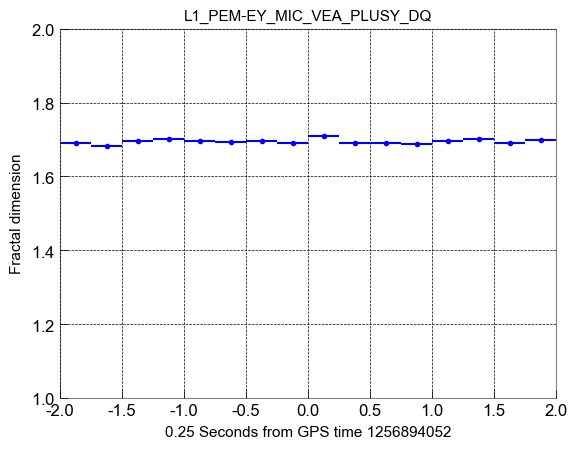

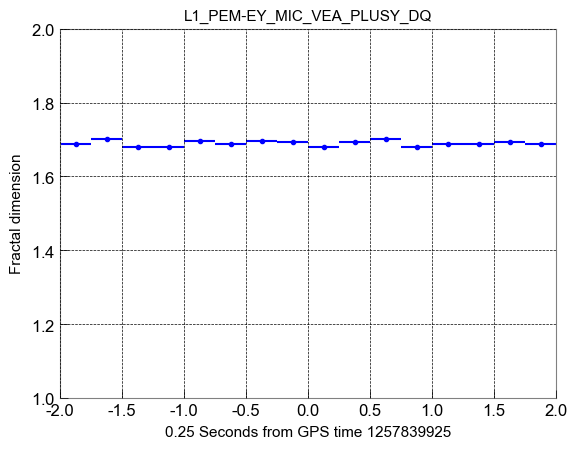

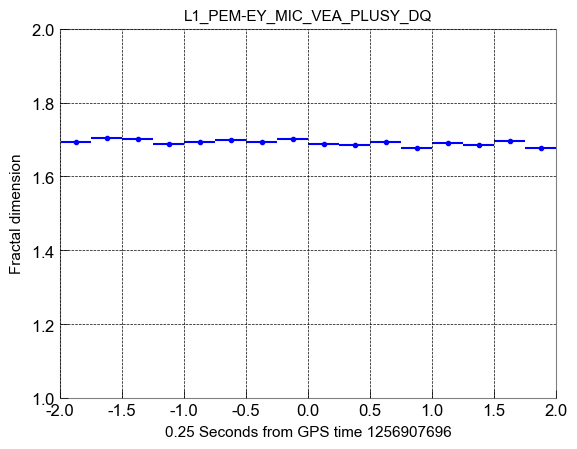

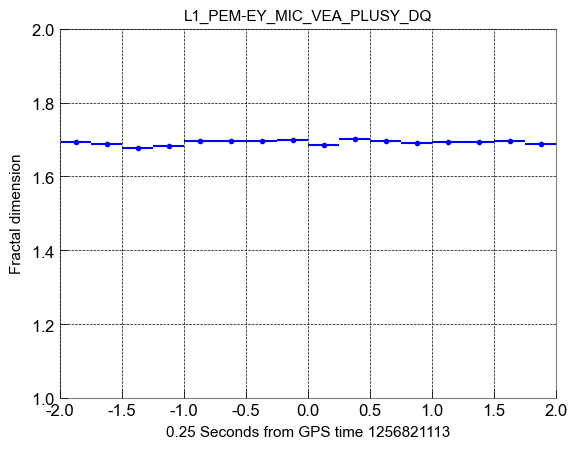

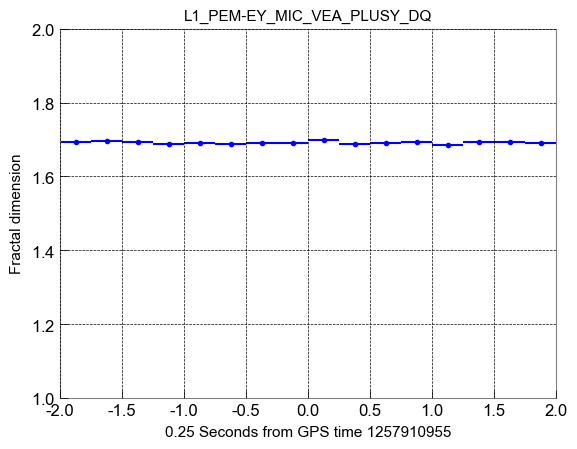

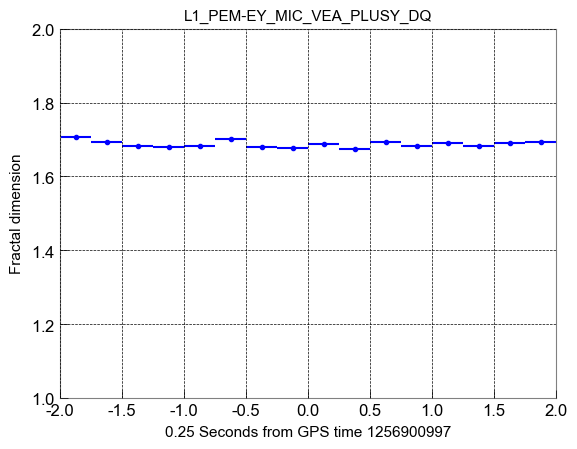

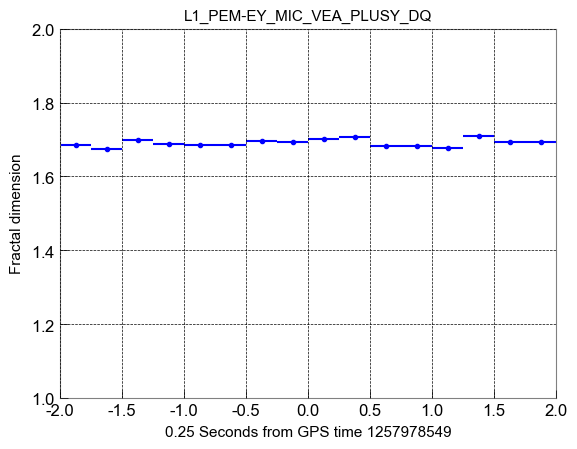

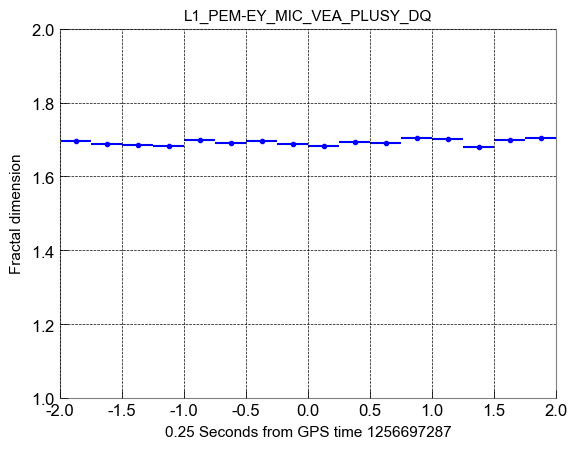

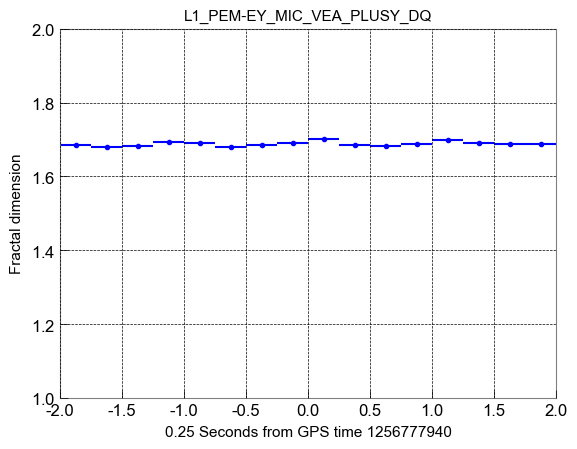

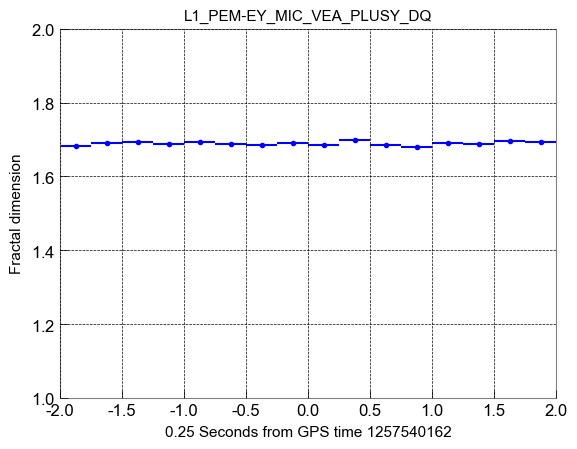

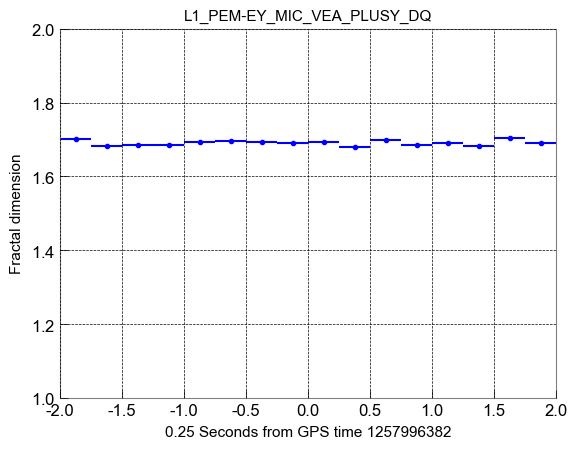

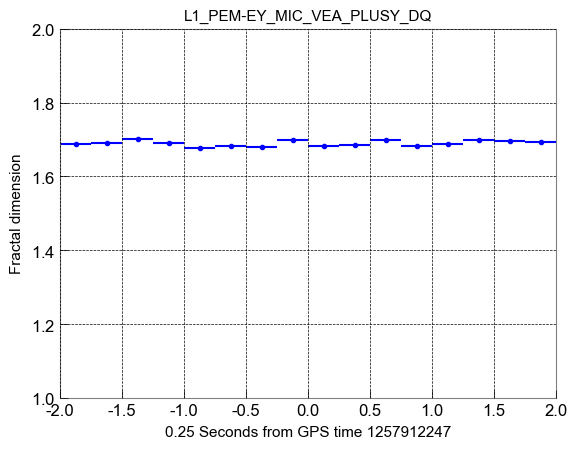

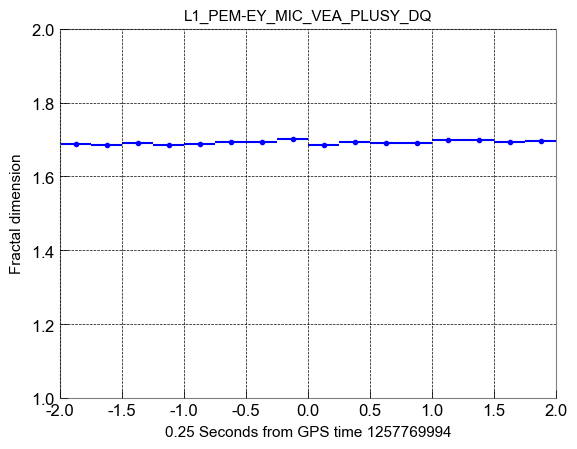

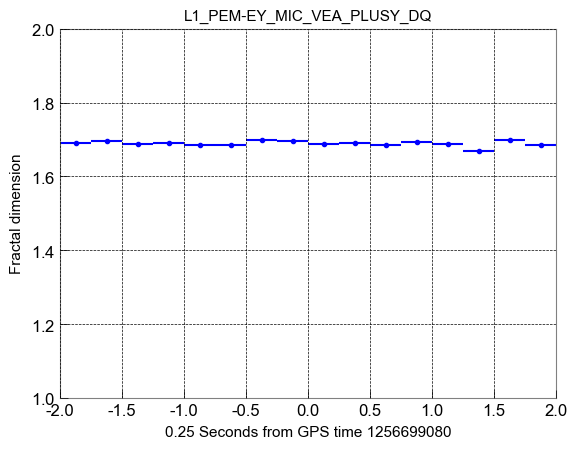

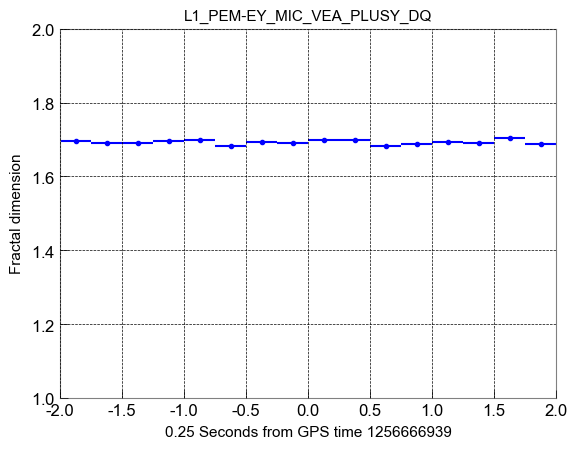

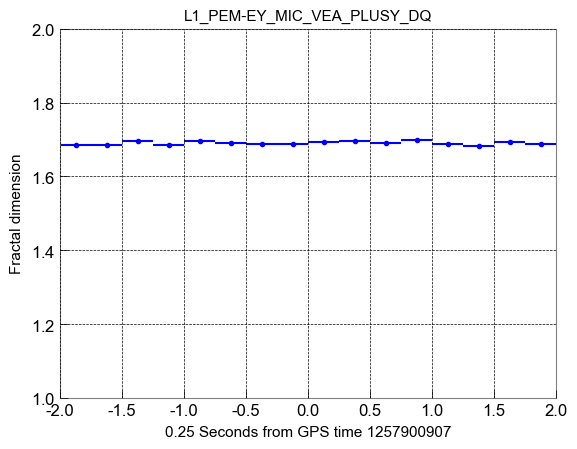

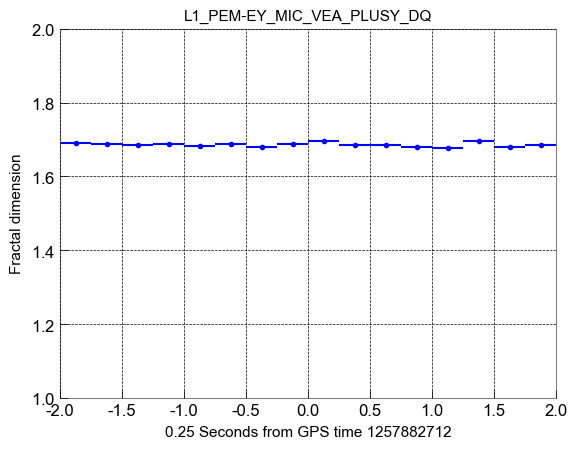

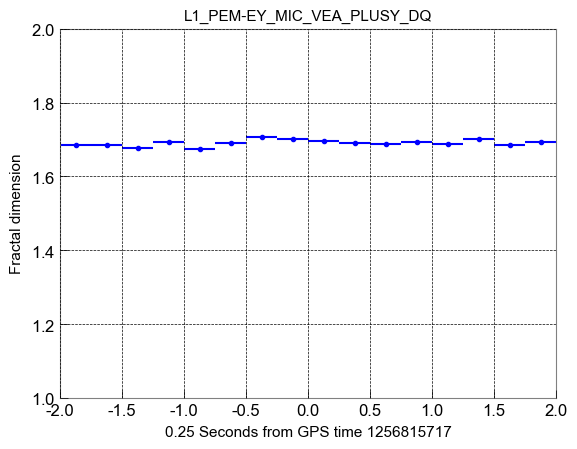

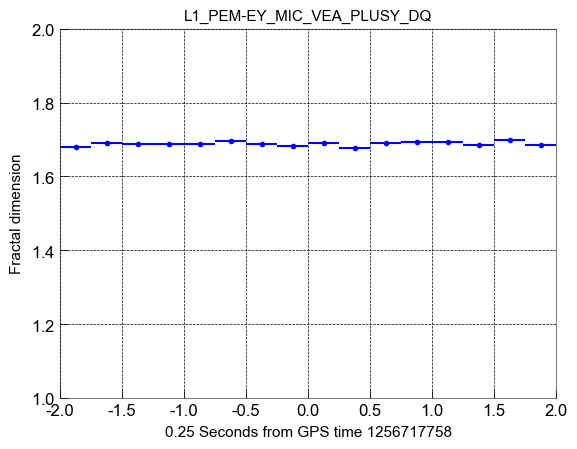

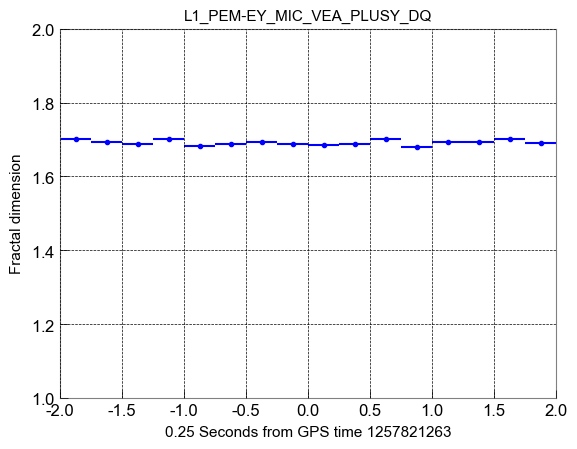

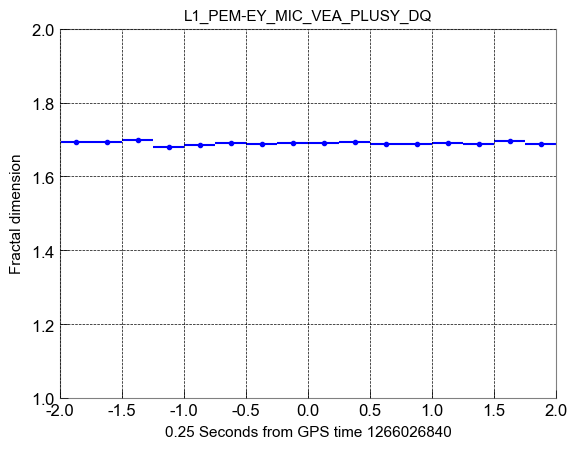

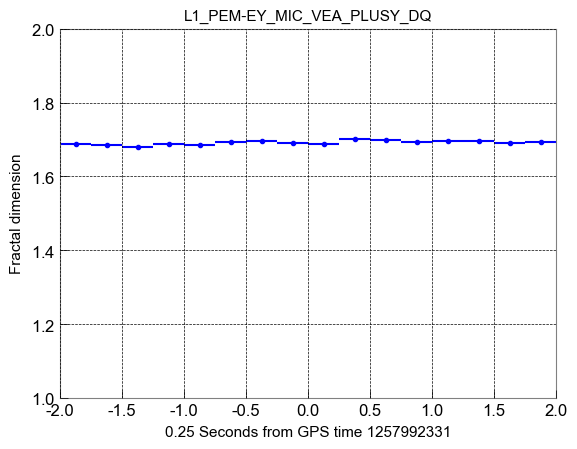

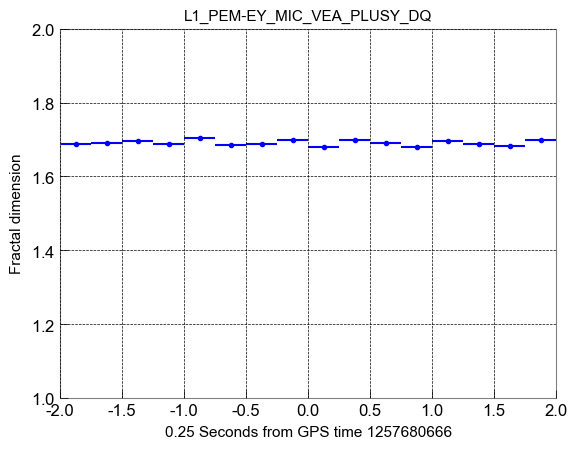

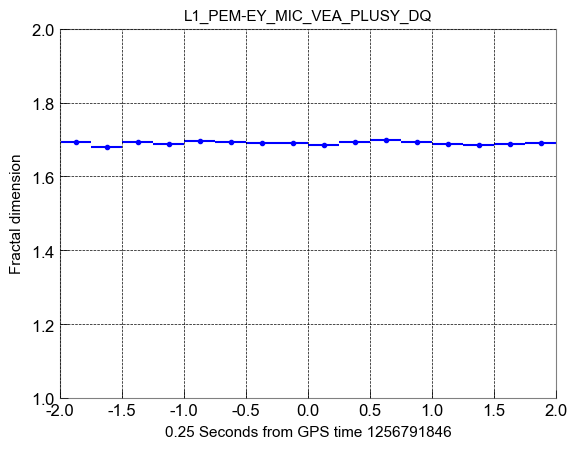

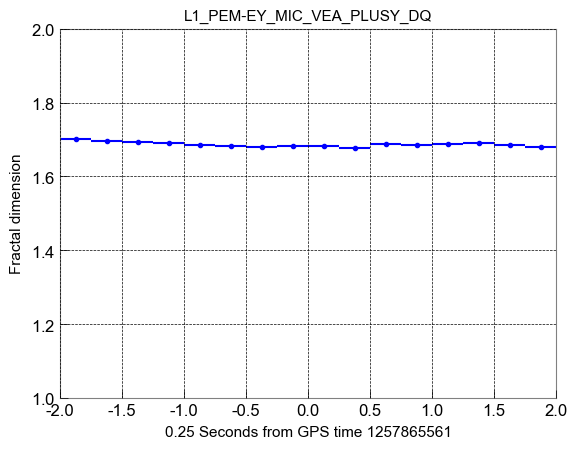

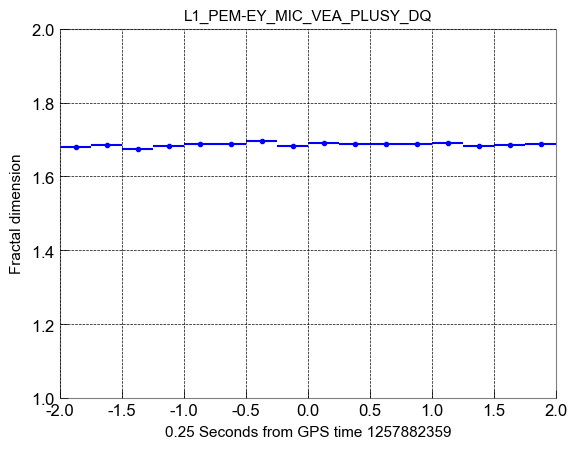

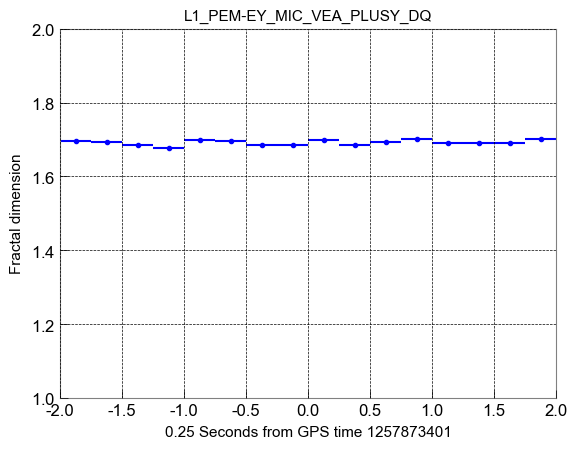

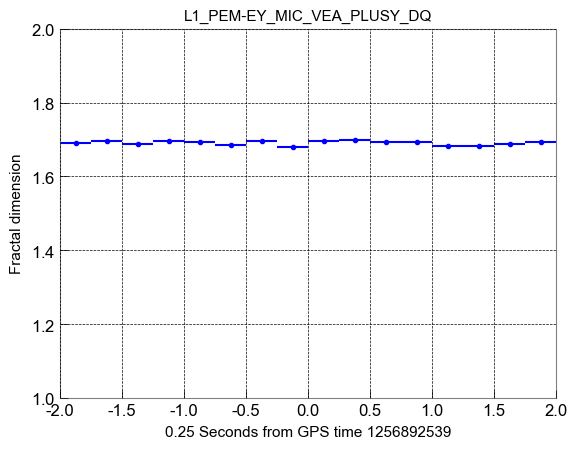

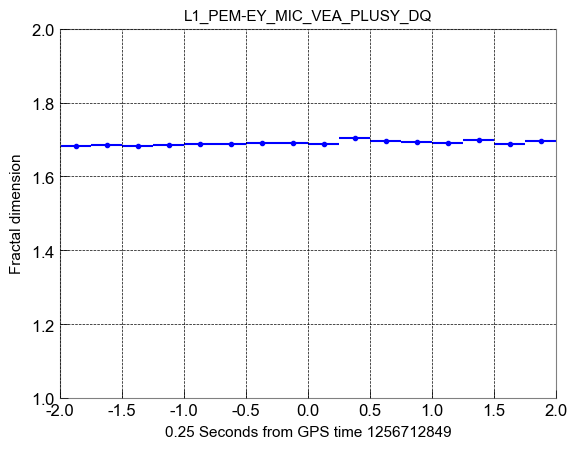

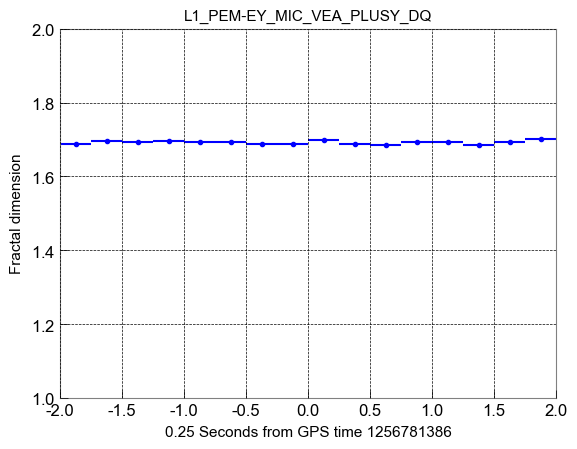

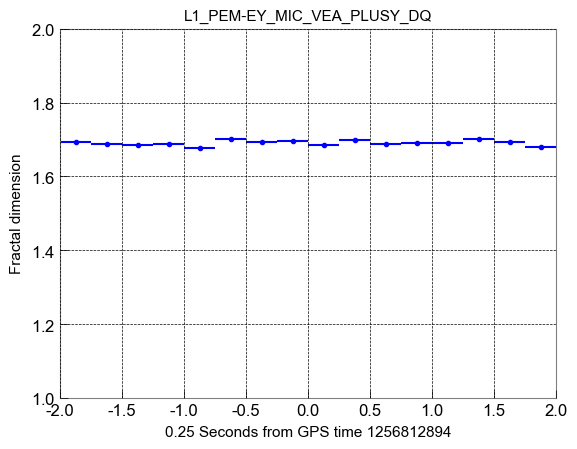

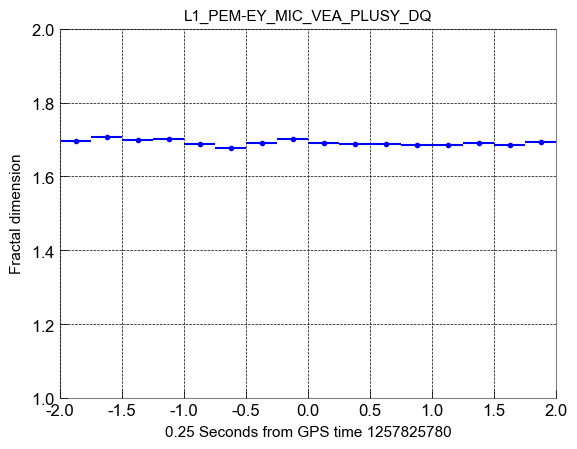

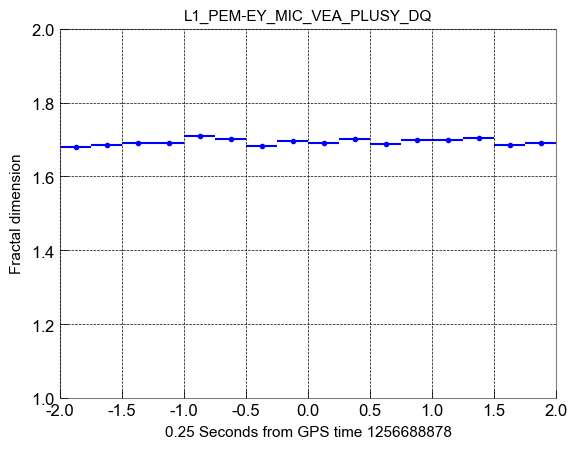

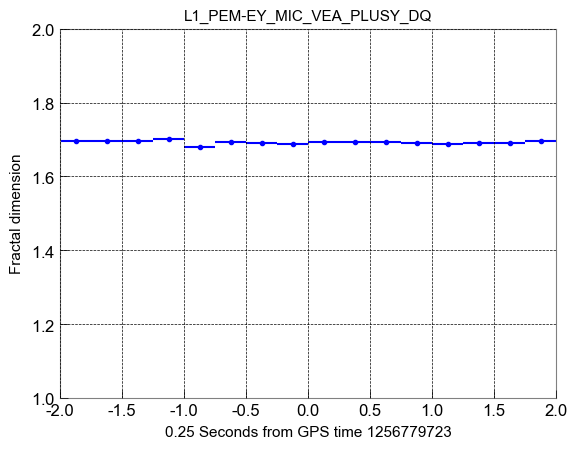

In [30]:
for glitch in valid_glitch_names_L1:
    filename = "FD_data/fd_calculation_" + glitch + "_aux_channel_L1_PEM-EY_MIC_VEA_PLUSY_DQ.txt"
    data_fd = pd.read_csv(filename, sep='\t')
    fig, ax = plt.subplots()
    plot_min_y = 1.0
    plot_max_y = 2.0

    glitch_start_time = int(O3b_csv[O3b_csv.id == glitch]['GPStime'])-2
    glitch_stop_time = int(O3b_csv[O3b_csv.id == glitch]['GPStime'])+2
    
    ax.set_title("L1_PEM-EY_MIC_VEA_PLUSY_DQ", fontsize=11)
    ax.tick_params(direction='in', length=6, width=0.5, colors='black', grid_color='r', grid_alpha=1)
    ax.set_xlabel(f"{step} Seconds from GPS time {glitch_start_time}", fontsize=11)
    ax.set_ylabel("Fractal dimension",fontsize=11)
    ax.set_xlim([glitch_start_time, glitch_stop_time])
    ax.set_ylim([plot_min_y, plot_max_y])
    ax.set_xticks(np.linspace(glitch_start_time, glitch_stop_time, 9))
    ax.set_xticklabels(np.linspace(-2, 2, 9))
    
    ax.grid(which='both', axis='both', linestyle='--', color='k', linewidth=0.5)
    
    time = data_fd['time'].values
    step = time[1]-time[0]
    fd = data_fd['fd'].values
    ax.errorbar(time+step/2, fd, xerr=step/2, fmt='.', c='b')